# Notebook 5 - Hyperparameter Tuning

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 6
NUM_TRIALS = 50

In [2]:
import numpy as np
import pandas as pd
import time
import pyarrow
import gc

# Model evaluation
from functools import partial
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Optuna
import optuna
from optuna.pruners import PercentilePruner

# Load and Prepare Data

In [3]:
def feature_engineering(data):
    df = data.copy()

    # ELU soil codes
    code = {
        1:2702,2:2703,3:2704,4:2705,5:2706,6:2717,7:3501,8:3502,9:4201,
        10:4703,11:4704,12:4744,13:4758,14:5101,15:5151,16:6101,17:6102,
        18:6731,19:7101,20:7102,21:7103,22:7201,23:7202,24:7700,25:7701,
        26:7702,27:7709,28:7710,29:7745,30:7746,31:7755,32:7756,33:7757,
        34:7790,35:8703,36:8707,37:8708,38:8771,39:8772,40:8776
    }
    
    # Soil Type
    df['Soil_Type'] = 0
    soil_features = list()
    for i in range(1,41):
        df['Soil_Type'] += i*df[f'Soil_Type{i}']
        soil_features.append(f'Soil_Type{i}')
    
    df['Climatic_Zone'] = df['Soil_Type'].apply(lambda x: int(str(code[x])[0]))
    df['Geologic_Zone'] = df['Soil_Type'].apply(lambda x: int(str(code[x])[1]))
    
    # Surface cover by rocks
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stony = [6,12]
    very_stony = [2,9,18,26]
    extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
    rubbly = [3,4,5,10,11,13]
    surface_cover = {i:0 for i in no_desc}
    surface_cover.update({i:1 for i in stony})
    surface_cover.update({i:2 for i in very_stony})
    surface_cover.update({i:3 for i in extremely_stony})
    surface_cover.update({i:4 for i in rubbly})
    df['Surface_Cover'] = df['Soil_Type'].apply(lambda x: surface_cover[x])

    # Rock size
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
    boulders = [22]
    rubble = [3,4,5,10,11,13]
    rock_size = {i:0 for i in no_desc}
    rock_size.update({i:1 for i in stones})
    rock_size.update({i:2 for i in boulders})
    rock_size.update({i:3 for i in rubble})
    df['Rock_Size'] = df['Soil_Type'].apply(lambda x: rock_size[x])

    # Interaction Terms
    df['Rock_Area1'] = df['Wilderness_Area1']*df['Rock_Size']   
    df['Rock_Area3'] = df['Wilderness_Area3']*df['Rock_Size']  
    df['Rock_Area4'] = df['Wilderness_Area4']*df['Rock_Size']
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    
    
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
    
    return df.drop(soil_features, axis = 1)

In [4]:
%%time

# Load original data
original = feature_engineering(pd.read_feather('../data/original.feather'))

# Label Encode
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])
y_train = original['Cover_Type'].iloc[:15119]
y_test = original['Cover_Type'].iloc[15119:]

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]

Wall time: 1.37 s


# Scoring Function

In [5]:
def score_model(sklearn_model):
    
    # Original Training/Test Split
    features = [x for x in original.columns if x not in ['Id','Cover_Type']]
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],7))
    oof_preds = np.zeros((X_temp.shape[0],))
    scores, times = np.zeros(NUM_FOLDS), np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        # validation/holdout predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        test_preds += model.predict_proba(X_test)

        # Save scores and times
        scores[fold] = accuracy_score(y_valid, valid_preds)
        end = time.time()
        times[fold] = end-start
        print(f'Fold {fold} Accuracy: {round(scores[fold], 5)} in {round(end-start, 2)}s')
    
    test_preds = np.argmax(test_preds, axis = 1)
    test_score = accuracy_score(y_test, test_preds)
    print("\nTrain Accuracy:", round(scores.mean(), 5))
    print('Test Accuracy:', round(test_score, 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    time.sleep(0.5)
    
    return oof_preds, test_preds

# Hyperparameter Search

## AdaBoost

In [6]:
def adaboost_search(trials):

    def objective(trial):
        
        estimator_params = dict(
            max_depth = trial.suggest_categorical(
                "max_depth", [*range(3,33,3), None]
            ),
            min_samples_split = trial.suggest_int(
                "min_samples_split", 1,100
            ),
            min_samples_leaf = trial.suggest_int(
                "min_samples_leaf", 1,15
            ),
        )
        
        adaboost_params = dict(
            n_estimators = trial.suggest_int(
                    "n_estimators", 50, 250, 10
                ),
            learning_rate = trial.suggest_loguniform(
                    "learning_rate", 0.01, 1.0
                ),
        )

        oof_preds, test_preds = score_model(
            AdaBoostClassifier(
                base_estimator = DecisionTreeClassifier(
                    splitter = 'random',
                    random_state = RANDOM_SEED,
                    **estimator_params
                ),
                random_state = RANDOM_SEED,
                **adaboost_params
            )
        )
        return accuracy_score(y_test, test_preds), np.min(f1_score(y_train, oof_preds, average = None))
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(directions = ["maximize","maximize"])
    study.enqueue_trial({
        "max_depth": None,
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "n_estimators": 50, 
        "learning_rate": 1.0,
    })
    study.optimize(objective, n_trials=trials)
    
    return study

In [7]:
%%time
study = adaboost_search(NUM_TRIALS)

[I 2021-12-30 00:20:48,701] A new study created in memory with name: no-name-fae8166e-7bfd-4547-beb7-2ad8f22c57d2
[D 2021-12-30 00:20:48,702] Trial 0 popped from the trial queue.


Fold 0 Accuracy: 0.79881 in 0.33s
Fold 1 Accuracy: 0.8119 in 0.32s
Fold 2 Accuracy: 0.80476 in 0.29s
Fold 3 Accuracy: 0.80079 in 0.32s
Fold 4 Accuracy: 0.81508 in 0.32s
Fold 5 Accuracy: 0.81501 in 0.29s

Train Accuracy: 0.80773
Test Accuracy: 0.75456
Training Time: 1.88s


[I 2021-12-30 00:20:51,205] Trial 0 finished with values: [0.7545596075583193, 0.6533396048918156] and parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'learning_rate': 1.0}. 


Fold 0 Accuracy: 0.8127 in 11.64s
Fold 1 Accuracy: 0.81825 in 11.72s
Fold 2 Accuracy: 0.81667 in 11.32s
Fold 3 Accuracy: 0.81865 in 11.47s
Fold 4 Accuracy: 0.81508 in 11.62s
Fold 5 Accuracy: 0.81024 in 11.63s

Train Accuracy: 0.81527
Test Accuracy: 0.75648
Training Time: 69.41s


[I 2021-12-30 00:22:01,231] Trial 1 finished with values: [0.7564751640327765, 0.6723710875928846] and parameters: {'max_depth': 24, 'min_samples_split': 58, 'min_samples_leaf': 13, 'n_estimators': 60, 'learning_rate': 0.34034082344425376}. 


Fold 0 Accuracy: 0.86389 in 14.04s
Fold 1 Accuracy: 0.86746 in 13.58s
Fold 2 Accuracy: 0.87103 in 13.72s
Fold 3 Accuracy: 0.87063 in 13.92s
Fold 4 Accuracy: 0.86706 in 13.8s
Fold 5 Accuracy: 0.87098 in 14.03s

Train Accuracy: 0.86851
Test Accuracy: 0.77307
Training Time: 83.09s


[I 2021-12-30 00:23:24,930] Trial 2 finished with values: [0.7730719411620218, 0.744373371239043] and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 10, 'n_estimators': 70, 'learning_rate': 0.03964305169698591}. 


Fold 0 Accuracy: 0.80714 in 28.77s
Fold 1 Accuracy: 0.81548 in 27.56s
Fold 2 Accuracy: 0.8131 in 29.69s
Fold 3 Accuracy: 0.80675 in 26.12s
Fold 4 Accuracy: 0.80794 in 25.87s
Fold 5 Accuracy: 0.80905 in 25.74s

Train Accuracy: 0.80991
Test Accuracy: 0.74496
Training Time: 163.73s


[I 2021-12-30 00:26:09,259] Trial 3 finished with values: [0.7449606197638069, 0.6779289161913119] and parameters: {'max_depth': 27, 'min_samples_split': 82, 'min_samples_leaf': 10, 'n_estimators': 150, 'learning_rate': 0.13429630390800945}. 


Fold 0 Accuracy: 0.87341 in 36.49s
Fold 1 Accuracy: 0.86825 in 36.39s
Fold 2 Accuracy: 0.88214 in 36.39s
Fold 3 Accuracy: 0.86667 in 36.38s
Fold 4 Accuracy: 0.86944 in 37.08s
Fold 5 Accuracy: 0.87574 in 37.1s

Train Accuracy: 0.87261
Test Accuracy: 0.78658
Training Time: 219.82s


[I 2021-12-30 00:29:49,693] Trial 4 finished with values: [0.7865833293573167, 0.7522470615349159] and parameters: {'max_depth': 21, 'min_samples_split': 39, 'min_samples_leaf': 4, 'n_estimators': 200, 'learning_rate': 0.7996683824555965}. 


Fold 0 Accuracy: 0.79167 in 8.55s
Fold 1 Accuracy: 0.80675 in 8.51s
Fold 2 Accuracy: 0.79524 in 8.53s
Fold 3 Accuracy: 0.79603 in 8.48s
Fold 4 Accuracy: 0.77857 in 8.53s
Fold 5 Accuracy: 0.80508 in 8.49s

Train Accuracy: 0.79556
Test Accuracy: 0.74626
Training Time: 51.09s


[I 2021-12-30 00:30:41,373] Trial 5 finished with values: [0.7462612189936967, 0.6635687732342007] and parameters: {'max_depth': 21, 'min_samples_split': 87, 'min_samples_leaf': 12, 'n_estimators': 50, 'learning_rate': 0.08558340643414135}. 


Fold 0 Accuracy: 0.43611 in 14.81s
Fold 1 Accuracy: 0.4254 in 14.82s
Fold 2 Accuracy: 0.44484 in 14.87s
Fold 3 Accuracy: 0.45317 in 14.77s
Fold 4 Accuracy: 0.43611 in 14.89s
Fold 5 Accuracy: 0.43748 in 14.87s

Train Accuracy: 0.43885
Test Accuracy: 0.4755
Training Time: 89.01s


[I 2021-12-30 00:32:10,988] Trial 6 finished with values: [0.4754980181765811, 0.0] and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 1, 'n_estimators': 110, 'learning_rate': 0.0160947969196801}. 


Fold 0 Accuracy: 0.52262 in 16.06s
Fold 1 Accuracy: 0.49881 in 16.1s
Fold 2 Accuracy: 0.49643 in 16.15s
Fold 3 Accuracy: 0.52698 in 16.17s
Fold 4 Accuracy: 0.53016 in 16.15s
Fold 5 Accuracy: 0.52958 in 16.13s

Train Accuracy: 0.51743
Test Accuracy: 0.60327
Training Time: 96.76s


[I 2021-12-30 00:33:48,351] Trial 7 finished with values: [0.6032712898021357, 0.3575539568345324] and parameters: {'max_depth': 3, 'min_samples_split': 91, 'min_samples_leaf': 9, 'n_estimators': 120, 'learning_rate': 0.5462881683604381}. 


Fold 0 Accuracy: 0.8254 in 25.94s
Fold 1 Accuracy: 0.83968 in 25.98s
Fold 2 Accuracy: 0.83849 in 26.27s
Fold 3 Accuracy: 0.82619 in 25.97s
Fold 4 Accuracy: 0.83294 in 26.06s
Fold 5 Accuracy: 0.82771 in 26.71s

Train Accuracy: 0.83173
Test Accuracy: 0.75693
Training Time: 156.92s


[I 2021-12-30 00:36:25,886] Trial 8 finished with values: [0.7569275463736077, 0.7017307260058441] and parameters: {'max_depth': 24, 'min_samples_split': 75, 'min_samples_leaf': 7, 'n_estimators': 150, 'learning_rate': 0.37992938651317526}. 


Fold 0 Accuracy: 0.80556 in 32.54s
Fold 1 Accuracy: 0.80794 in 32.09s
Fold 2 Accuracy: 0.8127 in 31.04s
Fold 3 Accuracy: 0.80437 in 30.84s
Fold 4 Accuracy: 0.7996 in 30.4s
Fold 5 Accuracy: 0.80429 in 30.23s

Train Accuracy: 0.80574
Test Accuracy: 0.74796
Training Time: 187.15s


[I 2021-12-30 00:39:33,669] Trial 9 finished with values: [0.7479558856532948, 0.6831046312178387] and parameters: {'max_depth': 21, 'min_samples_split': 100, 'min_samples_leaf': 9, 'n_estimators': 180, 'learning_rate': 0.03006846669684094}. 


Fold 0 Accuracy: 0.81071 in 18.72s
Fold 1 Accuracy: 0.81508 in 18.67s
Fold 2 Accuracy: 0.81429 in 18.63s
Fold 3 Accuracy: 0.80794 in 18.66s
Fold 4 Accuracy: 0.79762 in 18.66s
Fold 5 Accuracy: 0.81739 in 18.64s

Train Accuracy: 0.8105
Test Accuracy: 0.74484
Training Time: 111.97s


[I 2021-12-30 00:41:26,245] Trial 10 finished with values: [0.7448369214674859, 0.6793126534255746] and parameters: {'max_depth': 12, 'min_samples_split': 72, 'min_samples_leaf': 10, 'n_estimators': 110, 'learning_rate': 0.3593115889769775}. 


Fold 0 Accuracy: 0.82341 in 37.13s
Fold 1 Accuracy: 0.81429 in 37.07s
Fold 2 Accuracy: 0.82183 in 37.06s
Fold 3 Accuracy: 0.80714 in 36.91s
Fold 4 Accuracy: 0.79802 in 37.05s
Fold 5 Accuracy: 0.81818 in 37.09s

Train Accuracy: 0.81381
Test Accuracy: 0.74974
Training Time: 222.31s


[I 2021-12-30 00:45:09,159] Trial 11 finished with values: [0.7497371411203178, 0.6888743740474635] and parameters: {'max_depth': 27, 'min_samples_split': 100, 'min_samples_leaf': 6, 'n_estimators': 220, 'learning_rate': 0.024873130049643113}. 


Fold 0 Accuracy: 0.8746 in 42.79s
Fold 1 Accuracy: 0.87302 in 42.82s
Fold 2 Accuracy: 0.87619 in 42.83s
Fold 3 Accuracy: 0.86349 in 42.87s
Fold 4 Accuracy: 0.86706 in 42.8s
Fold 5 Accuracy: 0.8678 in 42.72s

Train Accuracy: 0.87036
Test Accuracy: 0.78472
Training Time: 256.83s


[I 2021-12-30 00:49:26,606] Trial 12 finished with values: [0.784715485082869, 0.7402234636871509] and parameters: {'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 10, 'n_estimators': 240, 'learning_rate': 0.8601631533685945}. 


Fold 0 Accuracy: 0.85714 in 43.62s
Fold 1 Accuracy: 0.86389 in 43.53s
Fold 2 Accuracy: 0.86151 in 43.45s
Fold 3 Accuracy: 0.85952 in 43.44s
Fold 4 Accuracy: 0.85397 in 43.36s
Fold 5 Accuracy: 0.86661 in 43.47s

Train Accuracy: 0.86044
Test Accuracy: 0.77621
Training Time: 260.87s


[I 2021-12-30 00:53:48,082] Trial 13 finished with values: [0.7762050422959818, 0.7293146917258766] and parameters: {'max_depth': None, 'min_samples_split': 41, 'min_samples_leaf': 7, 'n_estimators': 240, 'learning_rate': 0.27485992669038356}. 


Fold 0 Accuracy: 0.8377 in 25.35s
Fold 1 Accuracy: 0.84048 in 25.18s
Fold 2 Accuracy: 0.84246 in 25.26s
Fold 3 Accuracy: 0.83135 in 25.27s
Fold 4 Accuracy: 0.83413 in 25.36s
Fold 5 Accuracy: 0.84279 in 25.5s

Train Accuracy: 0.83815
Test Accuracy: 0.75872
Training Time: 151.92s


[I 2021-12-30 00:56:20,601] Trial 14 finished with values: [0.7587247059073005, 0.7217715413286561] and parameters: {'max_depth': 21, 'min_samples_split': 79, 'min_samples_leaf': 13, 'n_estimators': 150, 'learning_rate': 0.014476274272169474}. 


Fold 0 Accuracy: 0.85119 in 22.12s
Fold 1 Accuracy: 0.85476 in 22.17s
Fold 2 Accuracy: 0.85516 in 22.31s
Fold 3 Accuracy: 0.86032 in 22.21s
Fold 4 Accuracy: 0.84563 in 22.17s
Fold 5 Accuracy: 0.8551 in 22.12s

Train Accuracy: 0.85369
Test Accuracy: 0.76822
Training Time: 133.1s


[I 2021-12-30 00:58:34,307] Trial 15 finished with values: [0.7682212008277183, 0.7367709975230804] and parameters: {'max_depth': None, 'min_samples_split': 73, 'min_samples_leaf': 5, 'n_estimators': 130, 'learning_rate': 0.014203125448927378}. 


Fold 0 Accuracy: 0.79921 in 28.84s
Fold 1 Accuracy: 0.80675 in 28.81s
Fold 2 Accuracy: 0.80198 in 28.89s
Fold 3 Accuracy: 0.80913 in 28.84s
Fold 4 Accuracy: 0.7996 in 28.86s
Fold 5 Accuracy: 0.81143 in 28.93s

Train Accuracy: 0.80468
Test Accuracy: 0.73608
Training Time: 173.17s


[I 2021-12-30 01:01:28,080] Trial 16 finished with values: [0.7360790820879566, 0.6598442714126808] and parameters: {'max_depth': 9, 'min_samples_split': 77, 'min_samples_leaf': 6, 'n_estimators': 180, 'learning_rate': 0.8486057956162338}. 


Fold 0 Accuracy: 0.85556 in 8.64s
Fold 1 Accuracy: 0.85159 in 8.64s
Fold 2 Accuracy: 0.85278 in 8.67s
Fold 3 Accuracy: 0.85119 in 8.66s
Fold 4 Accuracy: 0.84643 in 8.64s
Fold 5 Accuracy: 0.85709 in 8.62s

Train Accuracy: 0.85244
Test Accuracy: 0.76581
Training Time: 51.87s


[I 2021-12-30 01:02:20,555] Trial 17 finished with values: [0.7658126182864958, 0.7260083449235049] and parameters: {'max_depth': 18, 'min_samples_split': 54, 'min_samples_leaf': 7, 'n_estimators': 50, 'learning_rate': 0.029848823325986897}. 


Fold 0 Accuracy: 0.85913 in 35.93s
Fold 1 Accuracy: 0.85913 in 35.69s
Fold 2 Accuracy: 0.8623 in 35.93s
Fold 3 Accuracy: 0.85476 in 35.74s
Fold 4 Accuracy: 0.85437 in 35.77s
Fold 5 Accuracy: 0.8551 in 35.84s

Train Accuracy: 0.85746
Test Accuracy: 0.77306
Training Time: 214.9s


[I 2021-12-30 01:05:56,069] Trial 18 finished with values: [0.773056037095352, 0.7272727272727273] and parameters: {'max_depth': 24, 'min_samples_split': 49, 'min_samples_leaf': 3, 'n_estimators': 200, 'learning_rate': 0.07727726243525707}. 


Fold 0 Accuracy: 0.85079 in 16.84s
Fold 1 Accuracy: 0.85119 in 16.85s
Fold 2 Accuracy: 0.85397 in 16.94s
Fold 3 Accuracy: 0.84722 in 16.91s
Fold 4 Accuracy: 0.84246 in 16.9s
Fold 5 Accuracy: 0.84518 in 16.88s

Train Accuracy: 0.84847
Test Accuracy: 0.75475
Training Time: 101.32s


[I 2021-12-30 01:07:37,993] Trial 19 finished with values: [0.7547504563583575, 0.7212519845770017] and parameters: {'max_depth': 27, 'min_samples_split': 66, 'min_samples_leaf': 14, 'n_estimators': 100, 'learning_rate': 0.012129485788141917}. 


Fold 0 Accuracy: 0.81468 in 27.64s
Fold 1 Accuracy: 0.81905 in 27.64s
Fold 2 Accuracy: 0.81746 in 27.64s
Fold 3 Accuracy: 0.81111 in 27.71s
Fold 4 Accuracy: 0.80317 in 27.72s
Fold 5 Accuracy: 0.81818 in 27.49s

Train Accuracy: 0.81394
Test Accuracy: 0.74805
Training Time: 165.85s


[I 2021-12-30 01:10:24,472] Trial 20 finished with values: [0.7480530771718329, 0.6799007444168734] and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 14, 'n_estimators': 170, 'learning_rate': 0.11201206732605735}. 


Fold 0 Accuracy: 0.825 in 17.0s
Fold 1 Accuracy: 0.82183 in 16.9s
Fold 2 Accuracy: 0.83135 in 17.14s
Fold 3 Accuracy: 0.81508 in 17.01s
Fold 4 Accuracy: 0.8131 in 17.0s
Fold 5 Accuracy: 0.82969 in 16.91s

Train Accuracy: 0.82267
Test Accuracy: 0.76064
Training Time: 101.96s


[I 2021-12-30 01:12:07,040] Trial 21 finished with values: [0.7606437966187954, 0.7014604810996563] and parameters: {'max_depth': 18, 'min_samples_split': 94, 'min_samples_leaf': 2, 'n_estimators': 100, 'learning_rate': 0.03675160478935051}. 


Fold 0 Accuracy: 0.86627 in 29.21s
Fold 1 Accuracy: 0.86111 in 29.21s
Fold 2 Accuracy: 0.86111 in 29.16s
Fold 3 Accuracy: 0.85952 in 29.28s
Fold 4 Accuracy: 0.8619 in 29.35s
Fold 5 Accuracy: 0.86463 in 29.31s

Train Accuracy: 0.86242
Test Accuracy: 0.77748
Training Time: 175.52s


[I 2021-12-30 01:15:03,172] Trial 22 finished with values: [0.777484436103645, 0.7394724664507172] and parameters: {'max_depth': 30, 'min_samples_split': 37, 'min_samples_leaf': 4, 'n_estimators': 160, 'learning_rate': 0.16545055420439578}. 


Fold 0 Accuracy: 0.82262 in 13.81s
Fold 1 Accuracy: 0.82341 in 13.72s
Fold 2 Accuracy: 0.82897 in 13.63s
Fold 3 Accuracy: 0.82024 in 13.7s
Fold 4 Accuracy: 0.81429 in 13.71s
Fold 5 Accuracy: 0.82096 in 13.92s

Train Accuracy: 0.82175
Test Accuracy: 0.7594
Training Time: 82.49s


[I 2021-12-30 01:16:26,265] Trial 23 finished with values: [0.7593997451815095, 0.69720325919401] and parameters: {'max_depth': None, 'min_samples_split': 87, 'min_samples_leaf': 2, 'n_estimators': 80, 'learning_rate': 0.05792191824653263}. 


Fold 0 Accuracy: 0.87302 in 31.45s
Fold 1 Accuracy: 0.86825 in 31.38s
Fold 2 Accuracy: 0.87381 in 31.51s
Fold 3 Accuracy: 0.87024 in 31.5s
Fold 4 Accuracy: 0.87063 in 31.45s
Fold 5 Accuracy: 0.87535 in 31.37s

Train Accuracy: 0.87188
Test Accuracy: 0.77901
Training Time: 188.66s


[I 2021-12-30 01:19:35,558] Trial 24 finished with values: [0.7790147607409882, 0.7487638332940901] and parameters: {'max_depth': 30, 'min_samples_split': 32, 'min_samples_leaf': 3, 'n_estimators': 170, 'learning_rate': 0.0786644536622732}. 


Fold 0 Accuracy: 0.82817 in 38.43s
Fold 1 Accuracy: 0.82976 in 38.44s
Fold 2 Accuracy: 0.82857 in 38.37s
Fold 3 Accuracy: 0.82817 in 38.28s
Fold 4 Accuracy: 0.82262 in 38.3s
Fold 5 Accuracy: 0.83605 in 38.27s

Train Accuracy: 0.82889
Test Accuracy: 0.75455
Training Time: 230.09s


[I 2021-12-30 01:23:26,252] Trial 25 finished with values: [0.7545490048472061, 0.6998430845101996] and parameters: {'max_depth': 15, 'min_samples_split': 62, 'min_samples_leaf': 9, 'n_estimators': 220, 'learning_rate': 0.11711168793060897}. 


Fold 0 Accuracy: 0.81786 in 25.96s
Fold 1 Accuracy: 0.82302 in 26.13s
Fold 2 Accuracy: 0.82262 in 25.96s
Fold 3 Accuracy: 0.80913 in 25.85s
Fold 4 Accuracy: 0.81706 in 25.82s
Fold 5 Accuracy: 0.81262 in 25.9s

Train Accuracy: 0.81705
Test Accuracy: 0.75092
Training Time: 155.62s


[I 2021-12-30 01:26:02,481] Trial 26 finished with values: [0.750921110527962, 0.6760371797778281] and parameters: {'max_depth': 9, 'min_samples_split': 47, 'min_samples_leaf': 13, 'n_estimators': 160, 'learning_rate': 0.8372736422341351}. 


Fold 0 Accuracy: 0.54841 in 8.85s
Fold 1 Accuracy: 0.56587 in 8.89s
Fold 2 Accuracy: 0.60556 in 8.82s
Fold 3 Accuracy: 0.54841 in 8.82s
Fold 4 Accuracy: 0.58214 in 8.81s
Fold 5 Accuracy: 0.57046 in 8.85s

Train Accuracy: 0.57014
Test Accuracy: 0.68137
Training Time: 53.03s


[I 2021-12-30 01:26:56,110] Trial 27 finished with values: [0.6813690927436812, 0.4906731549067316] and parameters: {'max_depth': 6, 'min_samples_split': 64, 'min_samples_leaf': 7, 'n_estimators': 60, 'learning_rate': 0.24960554663804227}. 


Fold 0 Accuracy: 0.85754 in 39.84s
Fold 1 Accuracy: 0.84246 in 39.77s
Fold 2 Accuracy: 0.85437 in 39.84s
Fold 3 Accuracy: 0.85238 in 39.78s
Fold 4 Accuracy: 0.8504 in 39.96s
Fold 5 Accuracy: 0.86026 in 39.85s

Train Accuracy: 0.8529
Test Accuracy: 0.77019
Training Time: 239.05s


[I 2021-12-30 01:30:55,767] Trial 28 finished with values: [0.7701897708577417, 0.7244851258581236] and parameters: {'max_depth': None, 'min_samples_split': 33, 'min_samples_leaf': 13, 'n_estimators': 220, 'learning_rate': 0.09239510895228285}. 


Fold 0 Accuracy: 0.81151 in 41.08s
Fold 1 Accuracy: 0.80992 in 41.22s
Fold 2 Accuracy: 0.81389 in 41.16s
Fold 3 Accuracy: 0.81548 in 41.01s
Fold 4 Accuracy: 0.81429 in 41.21s
Fold 5 Accuracy: 0.82056 in 41.19s

Train Accuracy: 0.81427
Test Accuracy: 0.74596
Training Time: 246.86s


[I 2021-12-30 01:35:03,221] Trial 29 finished with values: [0.7459608088454884, 0.6806833114323259] and parameters: {'max_depth': 30, 'min_samples_split': 89, 'min_samples_leaf': 6, 'n_estimators': 240, 'learning_rate': 0.09538377855997067}. 


Fold 0 Accuracy: 0.86706 in 22.53s
Fold 1 Accuracy: 0.86548 in 22.39s
Fold 2 Accuracy: 0.8619 in 22.4s
Fold 3 Accuracy: 0.86984 in 22.53s
Fold 4 Accuracy: 0.86429 in 22.42s
Fold 5 Accuracy: 0.86701 in 22.25s

Train Accuracy: 0.86593
Test Accuracy: 0.77501
Training Time: 134.51s


[I 2021-12-30 01:37:18,333] Trial 30 finished with values: [0.7750051688216677, 0.7383243370100916] and parameters: {'max_depth': 27, 'min_samples_split': 21, 'min_samples_leaf': 10, 'n_estimators': 120, 'learning_rate': 0.11195302333116228}. 


Fold 0 Accuracy: 0.88651 in 18.67s
Fold 1 Accuracy: 0.87976 in 18.78s
Fold 2 Accuracy: 0.8873 in 18.76s
Fold 3 Accuracy: 0.87897 in 18.78s
Fold 4 Accuracy: 0.87738 in 18.67s
Fold 5 Accuracy: 0.88249 in 18.77s

Train Accuracy: 0.88207
Test Accuracy: 0.77191
Training Time: 112.43s


[I 2021-12-30 01:39:11,367] Trial 31 finished with values: [0.771910944295123, 0.7578845220766618] and parameters: {'max_depth': 27, 'min_samples_split': 15, 'min_samples_leaf': 3, 'n_estimators': 100, 'learning_rate': 0.011988603160760447}. 


Fold 0 Accuracy: 0.84722 in 38.63s
Fold 1 Accuracy: 0.84325 in 38.71s
Fold 2 Accuracy: 0.8504 in 38.63s
Fold 3 Accuracy: 0.83889 in 38.72s
Fold 4 Accuracy: 0.83889 in 38.87s
Fold 5 Accuracy: 0.84954 in 38.59s

Train Accuracy: 0.8447
Test Accuracy: 0.76462
Training Time: 232.14s


[I 2021-12-30 01:43:04,104] Trial 32 finished with values: [0.7646162790492196, 0.7143182335533804] and parameters: {'max_depth': None, 'min_samples_split': 61, 'min_samples_leaf': 6, 'n_estimators': 220, 'learning_rate': 0.25852749258763247}. 


Fold 0 Accuracy: 0.51349 in 33.64s
Fold 1 Accuracy: 0.5496 in 33.84s
Fold 2 Accuracy: 0.51667 in 33.85s
Fold 3 Accuracy: 0.5131 in 33.73s
Fold 4 Accuracy: 0.52103 in 33.85s
Fold 5 Accuracy: 0.52918 in 34.26s

Train Accuracy: 0.52384
Test Accuracy: 0.66437
Training Time: 203.16s


[I 2021-12-30 01:46:27,874] Trial 33 finished with values: [0.6643694125921331, 0.21665982765695527] and parameters: {'max_depth': 6, 'min_samples_split': 65, 'min_samples_leaf': 4, 'n_estimators': 230, 'learning_rate': 0.03861006464671741}. 


Fold 0 Accuracy: 0.84484 in 38.83s
Fold 1 Accuracy: 0.85159 in 38.67s
Fold 2 Accuracy: 0.85238 in 38.76s
Fold 3 Accuracy: 0.8369 in 38.68s
Fold 4 Accuracy: 0.82976 in 38.83s
Fold 5 Accuracy: 0.84915 in 38.71s

Train Accuracy: 0.8441
Test Accuracy: 0.76633
Training Time: 232.49s


[I 2021-12-30 01:50:20,969] Trial 34 finished with values: [0.7663286168940064, 0.7262008733624453] and parameters: {'max_depth': 12, 'min_samples_split': 69, 'min_samples_leaf': 6, 'n_estimators': 230, 'learning_rate': 0.011011416876917523}. 


Fold 0 Accuracy: 0.8377 in 22.68s
Fold 1 Accuracy: 0.8377 in 22.62s
Fold 2 Accuracy: 0.83889 in 22.66s
Fold 3 Accuracy: 0.84325 in 22.66s
Fold 4 Accuracy: 0.83254 in 22.58s
Fold 5 Accuracy: 0.842 in 22.46s

Train Accuracy: 0.83868
Test Accuracy: 0.76753
Training Time: 135.66s


[I 2021-12-30 01:52:37,234] Trial 35 finished with values: [0.7675302574868393, 0.7102678571428572] and parameters: {'max_depth': 21, 'min_samples_split': 73, 'min_samples_leaf': 1, 'n_estimators': 130, 'learning_rate': 0.03981222650552493}. 


Fold 0 Accuracy: 0.86746 in 37.28s
Fold 1 Accuracy: 0.87421 in 37.04s
Fold 2 Accuracy: 0.8746 in 37.4s
Fold 3 Accuracy: 0.87579 in 37.37s
Fold 4 Accuracy: 0.87579 in 37.32s
Fold 5 Accuracy: 0.88408 in 37.59s

Train Accuracy: 0.87532
Test Accuracy: 0.77865
Training Time: 223.99s


[I 2021-12-30 01:56:21,826] Trial 36 finished with values: [0.7786525014446194, 0.7490494296577946] and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 8, 'n_estimators': 200, 'learning_rate': 0.052147043109703216}. 


Fold 0 Accuracy: 0.76944 in 19.3s
Fold 1 Accuracy: 0.77103 in 19.29s
Fold 2 Accuracy: 0.79405 in 19.23s
Fold 3 Accuracy: 0.77024 in 19.19s
Fold 4 Accuracy: 0.78373 in 19.32s
Fold 5 Accuracy: 0.78126 in 19.25s

Train Accuracy: 0.77829
Test Accuracy: 0.72385
Training Time: 115.58s


[I 2021-12-30 01:58:18,012] Trial 37 finished with values: [0.723847087700325, 0.6275384958714573] and parameters: {'max_depth': 9, 'min_samples_split': 100, 'min_samples_leaf': 7, 'n_estimators': 120, 'learning_rate': 0.7602700196727633}. 


Fold 0 Accuracy: 0.85556 in 37.02s
Fold 1 Accuracy: 0.8496 in 36.87s
Fold 2 Accuracy: 0.85873 in 37.18s
Fold 3 Accuracy: 0.85397 in 37.12s
Fold 4 Accuracy: 0.84881 in 37.18s
Fold 5 Accuracy: 0.8559 in 37.04s

Train Accuracy: 0.85376
Test Accuracy: 0.77195
Training Time: 222.41s


[I 2021-12-30 02:02:01,055] Trial 38 finished with values: [0.771951588021057, 0.7276431967398687] and parameters: {'max_depth': 30, 'min_samples_split': 43, 'min_samples_leaf': 13, 'n_estimators': 210, 'learning_rate': 0.018456581820789145}. 


Fold 0 Accuracy: 0.82262 in 24.41s
Fold 1 Accuracy: 0.82937 in 24.41s
Fold 2 Accuracy: 0.82937 in 24.49s
Fold 3 Accuracy: 0.82381 in 24.45s
Fold 4 Accuracy: 0.82381 in 24.48s
Fold 5 Accuracy: 0.842 in 24.43s

Train Accuracy: 0.82849
Test Accuracy: 0.75772
Training Time: 146.68s


[I 2021-12-30 02:04:28,333] Trial 39 finished with values: [0.757724516825619, 0.7019252046913034] and parameters: {'max_depth': 18, 'min_samples_split': 55, 'min_samples_leaf': 15, 'n_estimators': 140, 'learning_rate': 0.05375181727245741}. 


Fold 0 Accuracy: 0.52857 in 29.44s
Fold 1 Accuracy: 0.54524 in 29.38s
Fold 2 Accuracy: 0.54008 in 29.54s
Fold 3 Accuracy: 0.55357 in 29.5s
Fold 4 Accuracy: 0.54484 in 29.41s
Fold 5 Accuracy: 0.553 in 29.3s

Train Accuracy: 0.54422
Test Accuracy: 0.65075
Training Time: 176.58s


[I 2021-12-30 02:07:25,508] Trial 40 finished with values: [0.6507537644042248, 0.1558109833971903] and parameters: {'max_depth': 6, 'min_samples_split': 63, 'min_samples_leaf': 8, 'n_estimators': 200, 'learning_rate': 0.025808680658232552}. 


Fold 0 Accuracy: 0.54802 in 14.81s
Fold 1 Accuracy: 0.5996 in 14.86s
Fold 2 Accuracy: 0.58254 in 14.78s
Fold 3 Accuracy: 0.55794 in 14.79s
Fold 4 Accuracy: 0.54524 in 14.81s
Fold 5 Accuracy: 0.60103 in 14.81s

Train Accuracy: 0.57239
Test Accuracy: 0.66529
Training Time: 88.87s


[I 2021-12-30 02:08:54,977] Trial 41 finished with values: [0.6652936155775032, 0.34693099504384284] and parameters: {'max_depth': 6, 'min_samples_split': 25, 'min_samples_leaf': 1, 'n_estimators': 100, 'learning_rate': 0.04009451388558072}. 


Fold 0 Accuracy: 0.83849 in 37.05s
Fold 1 Accuracy: 0.8369 in 37.19s
Fold 2 Accuracy: 0.825 in 37.25s
Fold 3 Accuracy: 0.82778 in 37.09s
Fold 4 Accuracy: 0.82262 in 37.08s
Fold 5 Accuracy: 0.83644 in 36.95s

Train Accuracy: 0.83121
Test Accuracy: 0.75749
Training Time: 222.61s


[I 2021-12-30 02:12:38,193] Trial 42 finished with values: [0.7574930242996467, 0.7156121787950768] and parameters: {'max_depth': 27, 'min_samples_split': 99, 'min_samples_leaf': 6, 'n_estimators': 220, 'learning_rate': 0.01455310930317332}. 


Fold 0 Accuracy: 0.84524 in 12.19s
Fold 1 Accuracy: 0.84444 in 12.29s
Fold 2 Accuracy: 0.85675 in 12.28s
Fold 3 Accuracy: 0.84365 in 12.27s
Fold 4 Accuracy: 0.84206 in 12.31s
Fold 5 Accuracy: 0.8547 in 12.29s

Train Accuracy: 0.84781
Test Accuracy: 0.76911
Training Time: 73.63s


[I 2021-12-30 02:13:52,426] Trial 43 finished with values: [0.7691135956797487, 0.7200541394089781] and parameters: {'max_depth': 15, 'min_samples_split': 45, 'min_samples_leaf': 14, 'n_estimators': 70, 'learning_rate': 0.049389592584438195}. 


Fold 0 Accuracy: 0.86746 in 39.75s
Fold 1 Accuracy: 0.87222 in 39.65s
Fold 2 Accuracy: 0.86587 in 39.73s
Fold 3 Accuracy: 0.87063 in 40.09s
Fold 4 Accuracy: 0.86944 in 39.76s
Fold 5 Accuracy: 0.88091 in 39.83s

Train Accuracy: 0.87109
Test Accuracy: 0.77685
Training Time: 238.81s


[I 2021-12-30 02:17:51,835] Trial 44 finished with values: [0.7768518076738888, 0.7429519071310117] and parameters: {'max_depth': None, 'min_samples_split': 11, 'min_samples_leaf': 9, 'n_estimators': 210, 'learning_rate': 0.13843207328738372}. 


Fold 0 Accuracy: 0.84048 in 10.51s
Fold 1 Accuracy: 0.83968 in 10.55s
Fold 2 Accuracy: 0.84365 in 10.56s
Fold 3 Accuracy: 0.8377 in 10.55s
Fold 4 Accuracy: 0.83175 in 10.51s
Fold 5 Accuracy: 0.84121 in 10.5s

Train Accuracy: 0.83908
Test Accuracy: 0.76976
Training Time: 63.17s


[I 2021-12-30 02:18:55,610] Trial 45 finished with values: [0.7697638952946935, 0.7102222222222221] and parameters: {'max_depth': 30, 'min_samples_split': 60, 'min_samples_leaf': 6, 'n_estimators': 60, 'learning_rate': 0.05610676188269947}. 


Fold 0 Accuracy: 0.86905 in 32.78s
Fold 1 Accuracy: 0.86587 in 32.89s
Fold 2 Accuracy: 0.87421 in 32.94s
Fold 3 Accuracy: 0.87222 in 32.96s
Fold 4 Accuracy: 0.86786 in 32.84s
Fold 5 Accuracy: 0.8678 in 32.77s

Train Accuracy: 0.8695
Test Accuracy: 0.78261
Training Time: 197.17s


[I 2021-12-30 02:22:13,385] Trial 46 finished with values: [0.7826126140454114, 0.7519145973543747] and parameters: {'max_depth': 24, 'min_samples_split': 32, 'min_samples_leaf': 10, 'n_estimators': 180, 'learning_rate': 0.7199058447891785}. 


Fold 0 Accuracy: 0.87698 in 12.37s
Fold 1 Accuracy: 0.8754 in 12.39s
Fold 2 Accuracy: 0.87302 in 12.35s
Fold 3 Accuracy: 0.87579 in 12.33s
Fold 4 Accuracy: 0.8746 in 12.39s
Fold 5 Accuracy: 0.87813 in 12.47s

Train Accuracy: 0.87565
Test Accuracy: 0.77544
Training Time: 74.3s


[I 2021-12-30 02:23:28,287] Trial 47 finished with values: [0.7754416470958291, 0.7484397503600575] and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 5, 'n_estimators': 70, 'learning_rate': 0.01746520713430181}. 


Fold 0 Accuracy: 0.85238 in 39.8s
Fold 1 Accuracy: 0.84921 in 39.59s
Fold 2 Accuracy: 0.85595 in 39.68s
Fold 3 Accuracy: 0.84802 in 39.74s
Fold 4 Accuracy: 0.84603 in 39.71s
Fold 5 Accuracy: 0.8559 in 39.68s

Train Accuracy: 0.85125
Test Accuracy: 0.76946
Training Time: 238.21s


[I 2021-12-30 02:27:27,111] Trial 48 finished with values: [0.7694599509094475, 0.7207658992477773] and parameters: {'max_depth': None, 'min_samples_split': 43, 'min_samples_leaf': 8, 'n_estimators': 220, 'learning_rate': 0.09954338250236865}. 


Fold 0 Accuracy: 0.81389 in 34.43s
Fold 1 Accuracy: 0.81825 in 34.49s
Fold 2 Accuracy: 0.82579 in 34.48s
Fold 3 Accuracy: 0.82262 in 34.38s
Fold 4 Accuracy: 0.81746 in 34.44s
Fold 5 Accuracy: 0.83009 in 34.4s

Train Accuracy: 0.82135
Test Accuracy: 0.75103
Training Time: 206.62s


[I 2021-12-30 02:30:54,360] Trial 49 finished with values: [0.7510324389946509, 0.6936697653829128] and parameters: {'max_depth': 30, 'min_samples_split': 80, 'min_samples_leaf': 15, 'n_estimators': 200, 'learning_rate': 0.33685163968314646}. 


Wall time: 2h 10min 5s


In [8]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_pareto_front(study, target_names=["accuracy",'f1'])
fig.show()

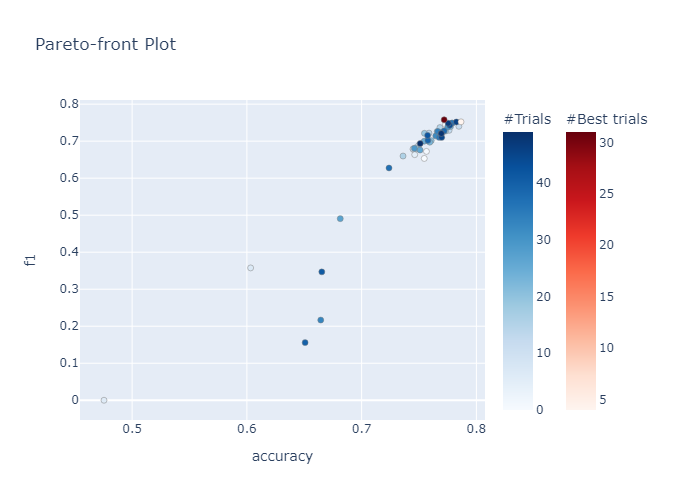

In [9]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [10]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[0], 
    target_name="accuracy"
)
fig.show()

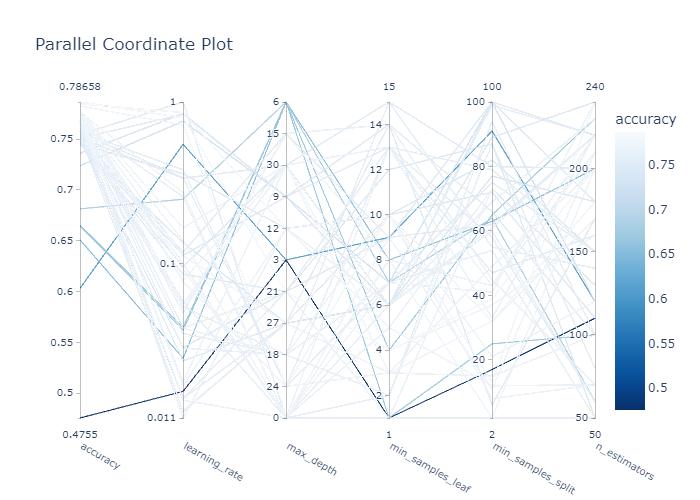

In [11]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [12]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[1], 
    target_name="worst_f1"
)
fig.show()

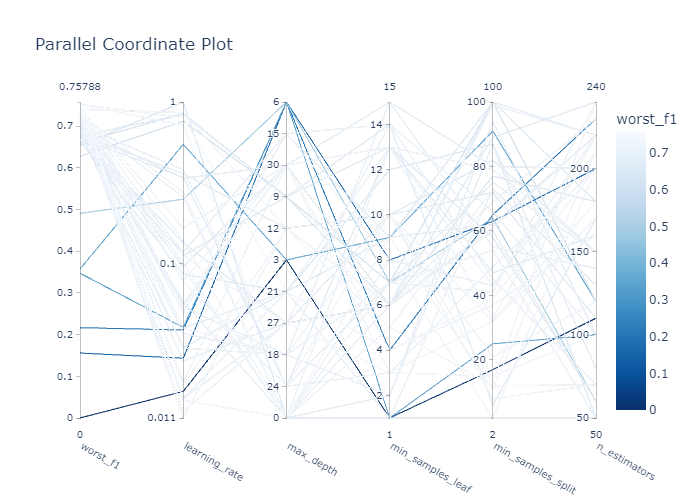

In [13]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

# ExtraTrees

In [14]:
def extratrees_search(trials):
    
    def objective(trial):
        model_params = dict(
            n_estimators = trial.suggest_int(
                "n_estimators", 50, 250, 10
            ),
            max_depth = trial.suggest_categorical(
                "max_depth", [*range(3,33,3), None]
            ),
            min_samples_split = trial.suggest_int(
                "min_samples_split", 2, 100
            ),
            min_samples_leaf = trial.suggest_int(
                "min_samples_leaf", 1, 15
            ),
            max_features = trial.suggest_discrete_uniform(
                "max_features", 0.2, 1.0, 0.01
            ),
        )

        oof_preds, test_preds = score_model(
            ExtraTreesClassifier(
                n_jobs = -1,
                random_state = RANDOM_SEED,
                **model_params
            )
        )
        return accuracy_score(y_test, test_preds), np.min(f1_score(y_train, oof_preds, average = None))
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(directions = ["maximize","maximize"])
    study.enqueue_trial({
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "max_features": 1.0,
    })
    study.optimize(objective, n_trials=trials)
    
    return study

In [15]:
study = extratrees_search(NUM_TRIALS)

[I 2021-12-30 02:30:57,664] A new study created in memory with name: no-name-868d284e-147f-4ebe-88ef-77eab56084fa
[D 2021-12-30 02:30:57,666] Trial 0 popped from the trial queue.


Fold 0 Accuracy: 0.89802 in 2.8s
Fold 1 Accuracy: 0.89524 in 2.78s
Fold 2 Accuracy: 0.89643 in 2.81s
Fold 3 Accuracy: 0.89722 in 2.77s
Fold 4 Accuracy: 0.90159 in 2.71s
Fold 5 Accuracy: 0.90195 in 2.88s

Train Accuracy: 0.89841
Test Accuracy: 0.80126
Training Time: 16.75s


[I 2021-12-30 02:31:15,046] Trial 0 finished with values: [0.8012627828935859, 0.7869638150011982] and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}. 


Fold 0 Accuracy: 0.7873 in 1.93s
Fold 1 Accuracy: 0.7869 in 1.94s
Fold 2 Accuracy: 0.78532 in 1.97s
Fold 3 Accuracy: 0.80079 in 1.99s
Fold 4 Accuracy: 0.78135 in 1.97s
Fold 5 Accuracy: 0.79238 in 2.01s

Train Accuracy: 0.78901
Test Accuracy: 0.65633
Training Time: 11.8s


[I 2021-12-30 02:31:27,482] Trial 1 finished with values: [0.6563325575683036, 0.6382448267265021] and parameters: {'n_estimators': 80, 'max_depth': 12, 'min_samples_split': 44, 'min_samples_leaf': 13, 'max_features': 0.27}. 


Fold 0 Accuracy: 0.83214 in 2.56s
Fold 1 Accuracy: 0.82341 in 2.56s
Fold 2 Accuracy: 0.83373 in 2.64s
Fold 3 Accuracy: 0.83254 in 2.55s
Fold 4 Accuracy: 0.82183 in 2.71s
Fold 5 Accuracy: 0.83843 in 2.61s

Train Accuracy: 0.83035
Test Accuracy: 0.69076
Training Time: 15.63s


[I 2021-12-30 02:31:43,737] Trial 2 finished with values: [0.6907595605529667, 0.6816008054366978] and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 0.8300000000000001}. 


Fold 0 Accuracy: 0.6246 in 1.69s
Fold 1 Accuracy: 0.63214 in 1.76s
Fold 2 Accuracy: 0.63651 in 1.77s
Fold 3 Accuracy: 0.63413 in 1.69s
Fold 4 Accuracy: 0.61151 in 1.77s
Fold 5 Accuracy: 0.63835 in 1.75s

Train Accuracy: 0.62954
Test Accuracy: 0.51565
Training Time: 10.43s


[I 2021-12-30 02:31:54,775] Trial 3 finished with values: [0.5156487180438705, 0.4415740462601382] and parameters: {'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 31, 'min_samples_leaf': 2, 'max_features': 0.31}. 


Fold 0 Accuracy: 0.68929 in 1.8s
Fold 1 Accuracy: 0.69127 in 1.86s
Fold 2 Accuracy: 0.69683 in 1.87s
Fold 3 Accuracy: 0.70794 in 1.84s
Fold 4 Accuracy: 0.68373 in 1.77s
Fold 5 Accuracy: 0.69274 in 1.81s

Train Accuracy: 0.69363
Test Accuracy: 0.56321
Training Time: 10.96s


[I 2021-12-30 02:32:06,341] Trial 4 finished with values: [0.5632107129793088, 0.5411167512690355] and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 60, 'min_samples_leaf': 5, 'max_features': 0.21000000000000002}. 


Fold 0 Accuracy: 0.82698 in 6.02s
Fold 1 Accuracy: 0.81349 in 5.9s
Fold 2 Accuracy: 0.82381 in 5.92s
Fold 3 Accuracy: 0.82659 in 5.91s
Fold 4 Accuracy: 0.81349 in 5.85s
Fold 5 Accuracy: 0.83247 in 5.87s

Train Accuracy: 0.82281
Test Accuracy: 0.68074
Training Time: 35.48s


[I 2021-12-30 02:32:42,442] Trial 5 finished with values: [0.6807399985509628, 0.6768537074148296] and parameters: {'n_estimators': 240, 'max_depth': 15, 'min_samples_split': 51, 'min_samples_leaf': 7, 'max_features': 0.62}. 


Fold 0 Accuracy: 0.81111 in 2.25s
Fold 1 Accuracy: 0.80794 in 2.29s
Fold 2 Accuracy: 0.8123 in 2.27s
Fold 3 Accuracy: 0.81429 in 2.22s
Fold 4 Accuracy: 0.80476 in 2.26s
Fold 5 Accuracy: 0.81937 in 2.26s

Train Accuracy: 0.81163
Test Accuracy: 0.66665
Training Time: 13.56s


[I 2021-12-30 02:32:56,617] Trial 6 finished with values: [0.6666489954814779, 0.6628053387056158] and parameters: {'n_estimators': 90, 'max_depth': 21, 'min_samples_split': 64, 'min_samples_leaf': 11, 'max_features': 0.6100000000000001}. 


Fold 0 Accuracy: 0.63016 in 4.27s
Fold 1 Accuracy: 0.64325 in 4.31s
Fold 2 Accuracy: 0.64603 in 4.3s
Fold 3 Accuracy: 0.65317 in 4.32s
Fold 4 Accuracy: 0.62143 in 4.32s
Fold 5 Accuracy: 0.64986 in 4.31s

Train Accuracy: 0.64065
Test Accuracy: 0.4946
Training Time: 25.84s


[I 2021-12-30 02:33:23,067] Trial 7 finished with values: [0.494597035128549, 0.40075614366729684] and parameters: {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 67, 'min_samples_leaf': 3, 'max_features': 0.74}. 


Fold 0 Accuracy: 0.87222 in 4.46s
Fold 1 Accuracy: 0.86429 in 4.41s
Fold 2 Accuracy: 0.86389 in 4.41s
Fold 3 Accuracy: 0.86151 in 4.39s
Fold 4 Accuracy: 0.86429 in 4.38s
Fold 5 Accuracy: 0.87257 in 4.46s

Train Accuracy: 0.86646
Test Accuracy: 0.74928
Training Time: 26.5s


[I 2021-12-30 02:33:50,172] Trial 8 finished with values: [0.7492812245424488, 0.7363233119763429] and parameters: {'n_estimators': 170, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.69}. 


Fold 0 Accuracy: 0.81111 in 1.54s
Fold 1 Accuracy: 0.80992 in 1.64s
Fold 2 Accuracy: 0.81786 in 1.52s
Fold 3 Accuracy: 0.82103 in 1.56s
Fold 4 Accuracy: 0.80992 in 1.54s
Fold 5 Accuracy: 0.82811 in 1.53s

Train Accuracy: 0.81632
Test Accuracy: 0.67562
Training Time: 9.33s


[I 2021-12-30 02:34:00,119] Trial 9 finished with values: [0.6756241904388285, 0.6638169474478249] and parameters: {'n_estimators': 60, 'max_depth': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'max_features': 0.81}. 


Fold 0 Accuracy: 0.80913 in 5.67s
Fold 1 Accuracy: 0.80357 in 5.69s
Fold 2 Accuracy: 0.8123 in 5.69s
Fold 3 Accuracy: 0.81389 in 5.62s
Fold 4 Accuracy: 0.80476 in 5.67s
Fold 5 Accuracy: 0.81818 in 5.71s

Train Accuracy: 0.81031
Test Accuracy: 0.6637
Training Time: 34.05s


[I 2021-12-30 02:34:34,773] Trial 10 finished with values: [0.663696140436443, 0.6556627729812087] and parameters: {'n_estimators': 230, 'max_depth': 30, 'min_samples_split': 69, 'min_samples_leaf': 11, 'max_features': 0.8300000000000001}. 


Fold 0 Accuracy: 0.62143 in 1.28s
Fold 1 Accuracy: 0.62619 in 1.31s
Fold 2 Accuracy: 0.63413 in 1.32s
Fold 3 Accuracy: 0.63056 in 1.34s
Fold 4 Accuracy: 0.61071 in 1.32s
Fold 5 Accuracy: 0.63478 in 1.32s

Train Accuracy: 0.6263
Test Accuracy: 0.44529
Training Time: 7.89s


[I 2021-12-30 02:34:43,265] Trial 11 finished with values: [0.4452855928594275, 0.2730030333670374] and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 64, 'min_samples_leaf': 4, 'max_features': 0.95}. 


Fold 0 Accuracy: 0.825 in 3.82s
Fold 1 Accuracy: 0.82183 in 3.72s
Fold 2 Accuracy: 0.83095 in 3.76s
Fold 3 Accuracy: 0.82897 in 3.83s
Fold 4 Accuracy: 0.81667 in 3.88s
Fold 5 Accuracy: 0.83565 in 3.75s

Train Accuracy: 0.82651
Test Accuracy: 0.68331
Training Time: 22.76s


[I 2021-12-30 02:35:06,644] Trial 12 finished with values: [0.6833111559959215, 0.6799395161290323] and parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 39, 'min_samples_leaf': 12, 'max_features': 0.8400000000000001}. 


Fold 0 Accuracy: 0.60159 in 3.88s
Fold 1 Accuracy: 0.61627 in 4.07s
Fold 2 Accuracy: 0.61667 in 4.12s
Fold 3 Accuracy: 0.60635 in 4.01s
Fold 4 Accuracy: 0.59008 in 3.99s
Fold 5 Accuracy: 0.62048 in 3.95s

Train Accuracy: 0.60857
Test Accuracy: 0.45792
Training Time: 24.02s


[I 2021-12-30 02:35:31,278] Trial 13 finished with values: [0.45792402450639963, 0.36971949983102403] and parameters: {'n_estimators': 190, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 0.25}. 


Fold 0 Accuracy: 0.79762 in 5.23s
Fold 1 Accuracy: 0.8004 in 5.13s
Fold 2 Accuracy: 0.80159 in 5.13s
Fold 3 Accuracy: 0.80675 in 5.49s
Fold 4 Accuracy: 0.79683 in 5.24s
Fold 5 Accuracy: 0.81421 in 5.18s

Train Accuracy: 0.8029
Test Accuracy: 0.65784
Training Time: 31.4s


[I 2021-12-30 02:36:03,278] Trial 14 finished with values: [0.6578399096649014, 0.6421267893660533] and parameters: {'n_estimators': 210, 'max_depth': 27, 'min_samples_split': 98, 'min_samples_leaf': 5, 'max_features': 0.98}. 


Fold 0 Accuracy: 0.8127 in 2.52s
Fold 1 Accuracy: 0.80833 in 2.57s
Fold 2 Accuracy: 0.81865 in 2.48s
Fold 3 Accuracy: 0.81667 in 2.63s
Fold 4 Accuracy: 0.80357 in 2.54s
Fold 5 Accuracy: 0.81937 in 2.69s

Train Accuracy: 0.81322
Test Accuracy: 0.66797
Training Time: 15.42s


[I 2021-12-30 02:36:19,303] Trial 15 finished with values: [0.6679672658965564, 0.6589303733602423] and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 62, 'min_samples_leaf': 11, 'max_features': 0.73}. 


Fold 0 Accuracy: 0.8377 in 6.39s
Fold 1 Accuracy: 0.82262 in 6.14s
Fold 2 Accuracy: 0.83373 in 6.13s
Fold 3 Accuracy: 0.8381 in 6.18s
Fold 4 Accuracy: 0.82738 in 6.18s
Fold 5 Accuracy: 0.84121 in 6.18s

Train Accuracy: 0.83346
Test Accuracy: 0.69738
Training Time: 37.2s


[I 2021-12-30 02:36:57,124] Trial 16 finished with values: [0.6973827207616987, 0.6930545182972367] and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 0.22}. 


Fold 0 Accuracy: 0.80635 in 4.57s
Fold 1 Accuracy: 0.80714 in 4.53s
Fold 2 Accuracy: 0.8127 in 4.48s
Fold 3 Accuracy: 0.8123 in 4.52s
Fold 4 Accuracy: 0.80437 in 4.47s
Fold 5 Accuracy: 0.81977 in 4.53s

Train Accuracy: 0.81044
Test Accuracy: 0.66395
Training Time: 27.1s


[I 2021-12-30 02:37:24,862] Trial 17 finished with values: [0.6639541397401982, 0.6508905852417303] and parameters: {'n_estimators': 180, 'max_depth': 21, 'min_samples_split': 66, 'min_samples_leaf': 12, 'max_features': 0.98}. 


Fold 0 Accuracy: 0.8246 in 4.3s
Fold 1 Accuracy: 0.81786 in 4.22s
Fold 2 Accuracy: 0.82222 in 4.2s
Fold 3 Accuracy: 0.83175 in 4.21s
Fold 4 Accuracy: 0.81786 in 4.17s
Fold 5 Accuracy: 0.83009 in 4.29s

Train Accuracy: 0.82406
Test Accuracy: 0.68791
Training Time: 25.39s


[I 2021-12-30 02:37:50,855] Trial 18 finished with values: [0.687912732619064, 0.6832204665161776] and parameters: {'n_estimators': 170, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.2}. 


Fold 0 Accuracy: 0.82579 in 3.39s
Fold 1 Accuracy: 0.82262 in 3.32s
Fold 2 Accuracy: 0.83056 in 3.34s
Fold 3 Accuracy: 0.82659 in 3.34s
Fold 4 Accuracy: 0.81905 in 3.29s
Fold 5 Accuracy: 0.83486 in 3.32s

Train Accuracy: 0.82658
Test Accuracy: 0.68217
Training Time: 20.0s


[I 2021-12-30 02:38:11,457] Trial 19 finished with values: [0.682171364551249, 0.6789500252397779] and parameters: {'n_estimators': 130, 'max_depth': 24, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.9299999999999999}. 


Fold 0 Accuracy: 0.81905 in 6.2s
Fold 1 Accuracy: 0.81905 in 6.33s
Fold 2 Accuracy: 0.82579 in 6.26s
Fold 3 Accuracy: 0.82738 in 6.26s
Fold 4 Accuracy: 0.82143 in 6.24s
Fold 5 Accuracy: 0.83843 in 6.22s

Train Accuracy: 0.82519
Test Accuracy: 0.68426
Training Time: 37.5s


[I 2021-12-30 02:38:49,560] Trial 20 finished with values: [0.6842583315220369, 0.6617534942820839] and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 44, 'min_samples_leaf': 1, 'max_features': 0.98}. 


Fold 0 Accuracy: 0.82302 in 6.14s
Fold 1 Accuracy: 0.81587 in 6.09s
Fold 2 Accuracy: 0.82698 in 6.09s
Fold 3 Accuracy: 0.82262 in 6.18s
Fold 4 Accuracy: 0.80754 in 6.13s
Fold 5 Accuracy: 0.82572 in 6.14s

Train Accuracy: 0.82029
Test Accuracy: 0.67866
Training Time: 36.78s


[I 2021-12-30 02:39:26,967] Trial 21 finished with values: [0.6786618671727694, 0.674880563238622] and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 47, 'min_samples_leaf': 9, 'max_features': 0.54}. 


Fold 0 Accuracy: 0.80119 in 1.29s
Fold 1 Accuracy: 0.79722 in 1.29s
Fold 2 Accuracy: 0.80437 in 1.3s
Fold 3 Accuracy: 0.80714 in 1.37s
Fold 4 Accuracy: 0.79841 in 1.27s
Fold 5 Accuracy: 0.80865 in 1.28s

Train Accuracy: 0.80283
Test Accuracy: 0.65632
Training Time: 7.81s


[I 2021-12-30 02:39:35,369] Trial 22 finished with values: [0.6563184206201526, 0.6453100973859558] and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 82, 'min_samples_leaf': 12, 'max_features': 0.72}. 


Fold 0 Accuracy: 0.81151 in 3.04s
Fold 1 Accuracy: 0.8119 in 3.0s
Fold 2 Accuracy: 0.81627 in 3.02s
Fold 3 Accuracy: 0.81825 in 3.01s
Fold 4 Accuracy: 0.80833 in 3.16s
Fold 5 Accuracy: 0.82136 in 3.07s

Train Accuracy: 0.8146
Test Accuracy: 0.67278
Training Time: 18.31s


[I 2021-12-30 02:39:54,286] Trial 23 finished with values: [0.6727791296234447, 0.6624557857503789] and parameters: {'n_estimators': 120, 'max_depth': 27, 'min_samples_split': 65, 'min_samples_leaf': 7, 'max_features': 0.69}. 


Fold 0 Accuracy: 0.83294 in 6.03s
Fold 1 Accuracy: 0.82976 in 6.02s
Fold 2 Accuracy: 0.8373 in 6.03s
Fold 3 Accuracy: 0.83651 in 6.06s
Fold 4 Accuracy: 0.8246 in 6.02s
Fold 5 Accuracy: 0.84041 in 6.03s

Train Accuracy: 0.83359
Test Accuracy: 0.697
Training Time: 36.19s


[I 2021-12-30 02:40:31,083] Trial 24 finished with values: [0.6969957218060658, 0.6882205513784461] and parameters: {'n_estimators': 240, 'max_depth': 18, 'min_samples_split': 35, 'min_samples_leaf': 8, 'max_features': 0.72}. 


Fold 0 Accuracy: 0.83095 in 3.58s
Fold 1 Accuracy: 0.82381 in 3.6s
Fold 2 Accuracy: 0.83413 in 3.56s
Fold 3 Accuracy: 0.82976 in 3.58s
Fold 4 Accuracy: 0.82421 in 3.56s
Fold 5 Accuracy: 0.83922 in 3.58s

Train Accuracy: 0.83035
Test Accuracy: 0.68755
Training Time: 21.47s


[I 2021-12-30 02:40:53,158] Trial 25 finished with values: [0.6875522404412141, 0.6833839918946302] and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': 0.94}. 


Fold 0 Accuracy: 0.87738 in 6.11s
Fold 1 Accuracy: 0.86349 in 6.09s
Fold 2 Accuracy: 0.86905 in 6.06s
Fold 3 Accuracy: 0.86746 in 6.09s
Fold 4 Accuracy: 0.86349 in 6.06s
Fold 5 Accuracy: 0.87336 in 6.03s

Train Accuracy: 0.86904
Test Accuracy: 0.76191
Training Time: 36.44s


[I 2021-12-30 02:41:30,207] Trial 26 finished with values: [0.7619090534783077, 0.7459697117733268] and parameters: {'n_estimators': 240, 'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.25}. 


Fold 0 Accuracy: 0.61587 in 2.89s
Fold 1 Accuracy: 0.62857 in 2.84s
Fold 2 Accuracy: 0.62183 in 2.86s
Fold 3 Accuracy: 0.62976 in 2.96s
Fold 4 Accuracy: 0.60317 in 2.95s
Fold 5 Accuracy: 0.62684 in 2.93s

Train Accuracy: 0.62101
Test Accuracy: 0.48013
Training Time: 17.44s


[I 2021-12-30 02:41:48,235] Trial 27 finished with values: [0.48013140293306333, 0.3250164149704531] and parameters: {'n_estimators': 140, 'max_depth': 3, 'min_samples_split': 35, 'min_samples_leaf': 7, 'max_features': 0.42000000000000004}. 


Fold 0 Accuracy: 0.8123 in 3.39s
Fold 1 Accuracy: 0.80952 in 3.25s
Fold 2 Accuracy: 0.81389 in 3.19s
Fold 3 Accuracy: 0.81667 in 3.23s
Fold 4 Accuracy: 0.80992 in 3.22s
Fold 5 Accuracy: 0.81977 in 3.24s

Train Accuracy: 0.81368
Test Accuracy: 0.66942
Training Time: 19.51s


[I 2021-12-30 02:42:08,346] Trial 28 finished with values: [0.6694198373190692, 0.6626201315123926] and parameters: {'n_estimators': 130, 'max_depth': 21, 'min_samples_split': 57, 'min_samples_leaf': 12, 'max_features': 0.5800000000000001}. 


Fold 0 Accuracy: 0.79722 in 5.88s
Fold 1 Accuracy: 0.79484 in 5.82s
Fold 2 Accuracy: 0.79762 in 5.84s
Fold 3 Accuracy: 0.80159 in 5.83s
Fold 4 Accuracy: 0.79722 in 5.85s
Fold 5 Accuracy: 0.80905 in 5.86s

Train Accuracy: 0.79959
Test Accuracy: 0.65229
Training Time: 35.09s


[I 2021-12-30 02:42:44,036] Trial 29 finished with values: [0.6522876232786057, 0.6376440460947502] and parameters: {'n_estimators': 240, 'max_depth': 27, 'min_samples_split': 98, 'min_samples_leaf': 9, 'max_features': 0.9000000000000001}. 


Fold 0 Accuracy: 0.72143 in 1.19s
Fold 1 Accuracy: 0.71984 in 1.18s
Fold 2 Accuracy: 0.71627 in 1.18s
Fold 3 Accuracy: 0.72183 in 1.21s
Fold 4 Accuracy: 0.71984 in 1.22s
Fold 5 Accuracy: 0.71497 in 1.21s

Train Accuracy: 0.71903
Test Accuracy: 0.58355
Training Time: 7.2s


[I 2021-12-30 02:42:51,829] Trial 30 finished with values: [0.583548480013006, 0.545798432855985] and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 64, 'min_samples_leaf': 6, 'max_features': 0.69}. 


Fold 0 Accuracy: 0.63889 in 2.07s
Fold 1 Accuracy: 0.64603 in 2.1s
Fold 2 Accuracy: 0.64762 in 2.07s
Fold 3 Accuracy: 0.65556 in 2.13s
Fold 4 Accuracy: 0.63135 in 2.12s
Fold 5 Accuracy: 0.65264 in 2.13s

Train Accuracy: 0.64535
Test Accuracy: 0.49829
Training Time: 12.61s


[I 2021-12-30 02:43:05,037] Trial 31 finished with values: [0.4982903128329914, 0.40601503759398494] and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 73, 'min_samples_leaf': 3, 'max_features': 0.76}. 


Fold 0 Accuracy: 0.58452 in 1.69s
Fold 1 Accuracy: 0.58929 in 1.74s
Fold 2 Accuracy: 0.59048 in 1.76s
Fold 3 Accuracy: 0.59127 in 1.66s
Fold 4 Accuracy: 0.56548 in 1.74s
Fold 5 Accuracy: 0.59984 in 1.78s

Train Accuracy: 0.58681
Test Accuracy: 0.41815
Training Time: 10.38s


[I 2021-12-30 02:43:16,029] Trial 32 finished with values: [0.4181514880021488, 0.4390697674418605] and parameters: {'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 60, 'min_samples_leaf': 12, 'max_features': 0.24000000000000002}. 


Fold 0 Accuracy: 0.82698 in 5.61s
Fold 1 Accuracy: 0.82024 in 5.53s
Fold 2 Accuracy: 0.82659 in 5.49s
Fold 3 Accuracy: 0.82579 in 5.54s
Fold 4 Accuracy: 0.81746 in 5.49s
Fold 5 Accuracy: 0.83049 in 5.6s

Train Accuracy: 0.82459
Test Accuracy: 0.67831
Training Time: 33.27s


[I 2021-12-30 02:43:49,901] Trial 33 finished with values: [0.6783102105875138, 0.673091554653817] and parameters: {'n_estimators': 220, 'max_depth': None, 'min_samples_split': 37, 'min_samples_leaf': 15, 'max_features': 0.9000000000000001}. 


Fold 0 Accuracy: 0.625 in 1.9s
Fold 1 Accuracy: 0.64762 in 1.95s
Fold 2 Accuracy: 0.64603 in 1.96s
Fold 3 Accuracy: 0.63373 in 1.96s
Fold 4 Accuracy: 0.61667 in 1.96s
Fold 5 Accuracy: 0.64232 in 1.96s

Train Accuracy: 0.63523
Test Accuracy: 0.43996
Training Time: 11.69s


[I 2021-12-30 02:44:02,201] Trial 34 finished with values: [0.43996479899910407, 0.2873359347286272] and parameters: {'n_estimators': 90, 'max_depth': 3, 'min_samples_split': 48, 'min_samples_leaf': 7, 'max_features': 0.99}. 


Fold 0 Accuracy: 0.62698 in 3.88s
Fold 1 Accuracy: 0.64008 in 3.86s
Fold 2 Accuracy: 0.64444 in 3.87s
Fold 3 Accuracy: 0.65238 in 3.93s
Fold 4 Accuracy: 0.61587 in 3.93s
Fold 5 Accuracy: 0.64391 in 3.97s

Train Accuracy: 0.63728
Test Accuracy: 0.49135
Training Time: 23.45s


[I 2021-12-30 02:44:26,239] Trial 35 finished with values: [0.49135260552790017, 0.3710874475637303] and parameters: {'n_estimators': 190, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_features': 0.53}. 


Fold 0 Accuracy: 0.77262 in 3.15s
Fold 1 Accuracy: 0.77341 in 3.16s
Fold 2 Accuracy: 0.77262 in 3.11s
Fold 3 Accuracy: 0.78532 in 3.12s
Fold 4 Accuracy: 0.76389 in 3.1s
Fold 5 Accuracy: 0.77848 in 3.06s

Train Accuracy: 0.77439
Test Accuracy: 0.64788
Training Time: 18.71s


[I 2021-12-30 02:44:45,547] Trial 36 finished with values: [0.6478751283369825, 0.6293810589112603] and parameters: {'n_estimators': 130, 'max_depth': 12, 'min_samples_split': 99, 'min_samples_leaf': 3, 'max_features': 0.26}. 


Fold 0 Accuracy: 0.81349 in 5.7s
Fold 1 Accuracy: 0.80357 in 5.54s
Fold 2 Accuracy: 0.8131 in 5.61s
Fold 3 Accuracy: 0.81825 in 5.59s
Fold 4 Accuracy: 0.80397 in 5.59s
Fold 5 Accuracy: 0.8158 in 5.62s

Train Accuracy: 0.81136
Test Accuracy: 0.6693
Training Time: 33.66s


[I 2021-12-30 02:45:19,820] Trial 37 finished with values: [0.6693049746153424, 0.6631286328026283] and parameters: {'n_estimators': 230, 'max_depth': 27, 'min_samples_split': 51, 'min_samples_leaf': 14, 'max_features': 0.45}. 


Fold 0 Accuracy: 0.80278 in 1.95s
Fold 1 Accuracy: 0.7996 in 2.04s
Fold 2 Accuracy: 0.80198 in 2.01s
Fold 3 Accuracy: 0.8119 in 1.99s
Fold 4 Accuracy: 0.80437 in 2.0s
Fold 5 Accuracy: 0.80905 in 2.02s

Train Accuracy: 0.80495
Test Accuracy: 0.66909
Training Time: 12.0s


[I 2021-12-30 02:45:32,431] Trial 38 finished with values: [0.6690876190375212, 0.6475182665658856] and parameters: {'n_estimators': 80, 'max_depth': 12, 'min_samples_split': 57, 'min_samples_leaf': 5, 'max_features': 0.47000000000000003}. 


Fold 0 Accuracy: 0.62698 in 1.1s
Fold 1 Accuracy: 0.64167 in 1.13s
Fold 2 Accuracy: 0.63968 in 1.14s
Fold 3 Accuracy: 0.63611 in 1.15s
Fold 4 Accuracy: 0.61905 in 1.12s
Fold 5 Accuracy: 0.64669 in 1.1s

Train Accuracy: 0.63503
Test Accuracy: 0.43266
Training Time: 6.74s


[I 2021-12-30 02:45:39,770] Trial 39 finished with values: [0.4326630652791252, 0.24888558692421994] and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 93, 'min_samples_leaf': 10, 'max_features': 0.97}. 


Fold 0 Accuracy: 0.85992 in 1.87s
Fold 1 Accuracy: 0.85516 in 1.93s
Fold 2 Accuracy: 0.86786 in 1.9s
Fold 3 Accuracy: 0.85675 in 1.93s
Fold 4 Accuracy: 0.85714 in 1.98s
Fold 5 Accuracy: 0.8678 in 1.91s

Train Accuracy: 0.86077
Test Accuracy: 0.744
Training Time: 11.52s


[I 2021-12-30 02:45:51,879] Trial 40 finished with values: [0.7440010744080595, 0.7299412915851272] and parameters: {'n_estimators': 70, 'max_depth': 27, 'min_samples_split': 22, 'min_samples_leaf': 2, 'max_features': 0.9299999999999999}. 


Fold 0 Accuracy: 0.77778 in 5.41s
Fold 1 Accuracy: 0.77302 in 5.18s
Fold 2 Accuracy: 0.78016 in 5.15s
Fold 3 Accuracy: 0.78095 in 5.15s
Fold 4 Accuracy: 0.76667 in 5.09s
Fold 5 Accuracy: 0.77491 in 5.08s

Train Accuracy: 0.77558
Test Accuracy: 0.63107
Training Time: 31.05s


[I 2021-12-30 02:46:23,555] Trial 41 finished with values: [0.6310698312225103, 0.6064246539566467] and parameters: {'n_estimators': 220, 'max_depth': 9, 'min_samples_split': 81, 'min_samples_leaf': 5, 'max_features': 0.6100000000000001}. 


Fold 0 Accuracy: 0.83929 in 3.53s
Fold 1 Accuracy: 0.82619 in 3.48s
Fold 2 Accuracy: 0.83373 in 3.49s
Fold 3 Accuracy: 0.8369 in 3.48s
Fold 4 Accuracy: 0.82778 in 3.45s
Fold 5 Accuracy: 0.83763 in 3.49s

Train Accuracy: 0.83359
Test Accuracy: 0.69879
Training Time: 20.93s


[I 2021-12-30 02:46:45,099] Trial 42 finished with values: [0.6987875799842019, 0.6955650212979204] and parameters: {'n_estimators': 140, 'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.25}. 


Fold 0 Accuracy: 0.81349 in 4.44s
Fold 1 Accuracy: 0.80714 in 4.38s
Fold 2 Accuracy: 0.81032 in 4.43s
Fold 3 Accuracy: 0.81667 in 4.37s
Fold 4 Accuracy: 0.80278 in 4.41s
Fold 5 Accuracy: 0.81342 in 4.36s

Train Accuracy: 0.81064
Test Accuracy: 0.67528
Training Time: 26.39s


[I 2021-12-30 02:47:12,089] Trial 43 finished with values: [0.6752849036832052, 0.668661181750187] and parameters: {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 61, 'min_samples_leaf': 3, 'max_features': 0.28}. 


Fold 0 Accuracy: 0.81151 in 1.78s
Fold 1 Accuracy: 0.8119 in 1.81s
Fold 2 Accuracy: 0.825 in 1.84s
Fold 3 Accuracy: 0.81667 in 1.88s
Fold 4 Accuracy: 0.8131 in 1.83s
Fold 5 Accuracy: 0.82652 in 1.75s

Train Accuracy: 0.81745
Test Accuracy: 0.66962
Training Time: 10.89s


[I 2021-12-30 02:47:23,618] Trial 44 finished with values: [0.6696195217117017, 0.657625383828045] and parameters: {'n_estimators': 70, 'max_depth': 12, 'min_samples_split': 32, 'min_samples_leaf': 14, 'max_features': 1.0}. 


Fold 0 Accuracy: 0.7127 in 5.27s
Fold 1 Accuracy: 0.70476 in 5.32s
Fold 2 Accuracy: 0.7119 in 5.3s
Fold 3 Accuracy: 0.7254 in 5.33s
Fold 4 Accuracy: 0.70833 in 5.38s
Fold 5 Accuracy: 0.70385 in 5.29s

Train Accuracy: 0.71116
Test Accuracy: 0.58718
Training Time: 31.9s


[I 2021-12-30 02:47:56,128] Trial 45 finished with values: [0.5871763743322501, 0.5437860513896172] and parameters: {'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 33, 'min_samples_leaf': 7, 'max_features': 0.41000000000000003}. 


Fold 0 Accuracy: 0.84365 in 3.34s
Fold 1 Accuracy: 0.82976 in 3.28s
Fold 2 Accuracy: 0.84524 in 3.24s
Fold 3 Accuracy: 0.83849 in 3.27s
Fold 4 Accuracy: 0.83373 in 3.26s
Fold 5 Accuracy: 0.84438 in 3.28s

Train Accuracy: 0.83921
Test Accuracy: 0.70318
Training Time: 19.68s


[I 2021-12-30 02:48:16,425] Trial 46 finished with values: [0.7031841708591553, 0.7027431421446384] and parameters: {'n_estimators': 130, 'max_depth': 27, 'min_samples_split': 29, 'min_samples_leaf': 7, 'max_features': 0.53}. 


Fold 0 Accuracy: 0.79643 in 4.62s
Fold 1 Accuracy: 0.79167 in 4.55s
Fold 2 Accuracy: 0.79762 in 4.64s
Fold 3 Accuracy: 0.80119 in 4.54s
Fold 4 Accuracy: 0.78532 in 4.6s
Fold 5 Accuracy: 0.8027 in 4.52s

Train Accuracy: 0.79582
Test Accuracy: 0.65732
Training Time: 27.48s


[I 2021-12-30 02:48:44,510] Trial 47 finished with values: [0.6573239110573907, 0.6485534591194968] and parameters: {'n_estimators': 190, 'max_depth': 21, 'min_samples_split': 83, 'min_samples_leaf': 10, 'max_features': 0.34}. 


Fold 0 Accuracy: 0.82976 in 3.05s
Fold 1 Accuracy: 0.82341 in 3.06s
Fold 2 Accuracy: 0.83016 in 3.06s
Fold 3 Accuracy: 0.83016 in 3.03s
Fold 4 Accuracy: 0.81984 in 3.02s
Fold 5 Accuracy: 0.83644 in 3.02s

Train Accuracy: 0.8283
Test Accuracy: 0.68693
Training Time: 18.25s


[I 2021-12-30 02:49:03,364] Trial 48 finished with values: [0.6869319818410901, 0.683049147442327] and parameters: {'n_estimators': 120, 'max_depth': None, 'min_samples_split': 45, 'min_samples_leaf': 8, 'max_features': 0.8}. 


Fold 0 Accuracy: 0.81151 in 2.46s
Fold 1 Accuracy: 0.80278 in 2.55s
Fold 2 Accuracy: 0.80397 in 2.45s
Fold 3 Accuracy: 0.81349 in 2.5s
Fold 4 Accuracy: 0.8 in 2.44s
Fold 5 Accuracy: 0.80627 in 2.54s

Train Accuracy: 0.80634
Test Accuracy: 0.6703
Training Time: 14.94s


[I 2021-12-30 02:49:18,915] Trial 49 finished with values: [0.6703033965785051, 0.6577380952380952] and parameters: {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 61, 'min_samples_leaf': 5, 'max_features': 0.26}. 


In [16]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_pareto_front(study, target_names=["accuracy",'f1'])
fig.show()

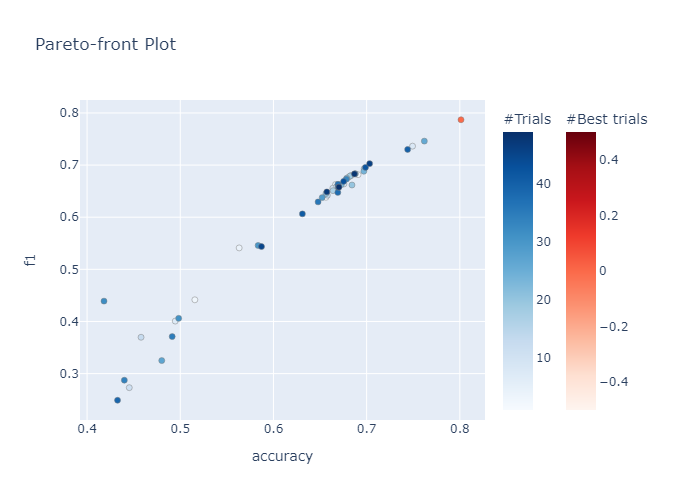

In [17]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [18]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[0], 
    target_name="accuracy"
)
fig.show()

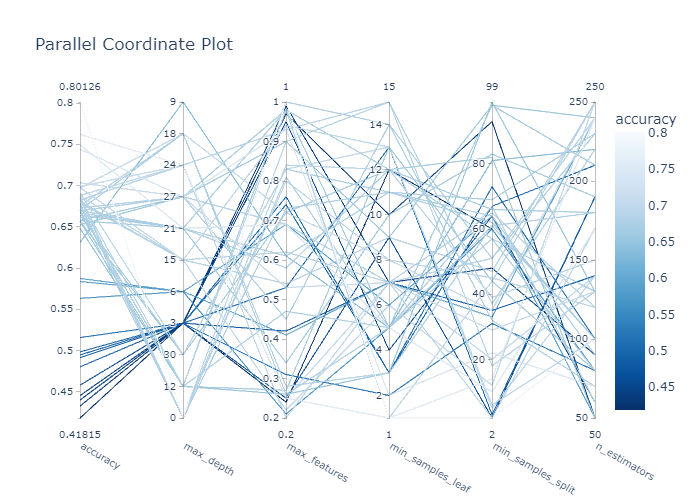

In [19]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [20]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[1], 
    target_name="worst_f1"
)
fig.show()

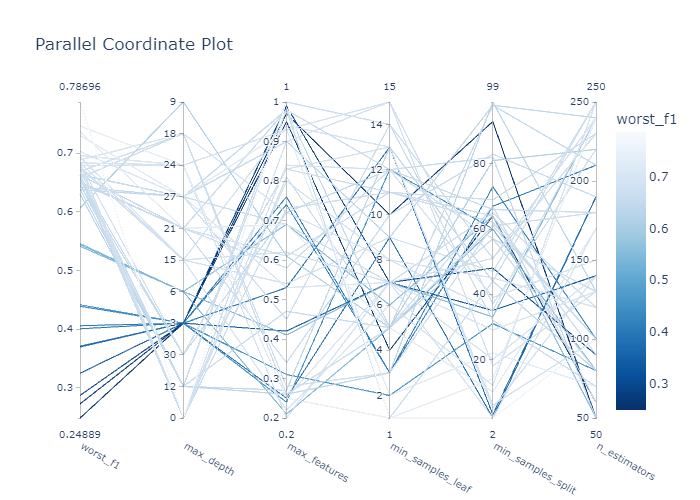

In [21]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

# Bagging

In [22]:
def bagging_search(trials):
    
    def objective(trial):
        
        estimator_params = dict(
            max_depth = trial.suggest_categorical(
                "max_depth", [*range(3,33,3), None]
            ),
            min_samples_split = trial.suggest_int(
                "min_samples_split", 1,100
            ),
            min_samples_leaf = trial.suggest_int(
                "min_samples_leaf", 1,15
            ),
        )

        bagging_params = dict(
            n_estimators = trial.suggest_int(
                    "n_estimators", 10, 250, 10
                ),
            max_samples = trial.suggest_discrete_uniform(
                    "max_samples", 0.2, 1.0, 0.01
                ),
            max_features = trial.suggest_discrete_uniform(
                    "max_features", 0.2, 1.0, 0.01
                ),
        )

        oof_preds, test_preds = score_model(
            BaggingClassifier(
                base_estimator = DecisionTreeClassifier(
                    splitter = 'random',
                    random_state = RANDOM_SEED,
                    **estimator_params
                ),
                n_jobs = -1,
                random_state = RANDOM_SEED,
                **bagging_params
            )
        )
        return accuracy_score(y_test, test_preds), np.min(f1_score(y_train, oof_preds, average = None))
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(directions = ["maximize","maximize"])
    study.enqueue_trial({
        "max_depth": None,
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "n_estimators": 10, 
        "max_samples": 1.0,
        "max_features": 1.0,
    })
    study.optimize(objective, n_trials=trials)
    
    return study

In [23]:
study = bagging_search(NUM_TRIALS)

[I 2021-12-30 02:49:20,337] A new study created in memory with name: no-name-fc95fdae-db1a-4d36-bbc5-d84b1479968e
[D 2021-12-30 02:49:20,339] Trial 0 popped from the trial queue.


Fold 0 Accuracy: 0.86151 in 3.39s
Fold 1 Accuracy: 0.8619 in 1.46s
Fold 2 Accuracy: 0.87063 in 1.38s
Fold 3 Accuracy: 0.87381 in 1.41s
Fold 4 Accuracy: 0.85873 in 1.41s
Fold 5 Accuracy: 0.87773 in 1.42s

Train Accuracy: 0.86739
Test Accuracy: 0.77502
Training Time: 10.46s


[I 2021-12-30 02:49:31,395] Trial 0 finished with values: [0.7750210728883375, 0.730778739184178] and parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0}. 


Fold 0 Accuracy: 0.79722 in 6.64s
Fold 1 Accuracy: 0.78889 in 6.38s
Fold 2 Accuracy: 0.79802 in 6.46s
Fold 3 Accuracy: 0.80317 in 6.41s
Fold 4 Accuracy: 0.79167 in 6.34s
Fold 5 Accuracy: 0.80429 in 6.4s

Train Accuracy: 0.79721
Test Accuracy: 0.65551
Training Time: 38.63s


[I 2021-12-30 02:50:10,653] Trial 1 finished with values: [0.6555143816940658, 0.6485525647536822] and parameters: {'max_depth': None, 'min_samples_split': 37, 'min_samples_leaf': 1, 'n_estimators': 140, 'max_samples': 0.42000000000000004, 'max_features': 0.44}. 


Fold 0 Accuracy: 0.76032 in 4.98s
Fold 1 Accuracy: 0.75159 in 5.02s
Fold 2 Accuracy: 0.75635 in 5.13s
Fold 3 Accuracy: 0.77262 in 5.07s
Fold 4 Accuracy: 0.75952 in 5.05s
Fold 5 Accuracy: 0.76102 in 5.06s

Train Accuracy: 0.76024
Test Accuracy: 0.61611
Training Time: 30.31s


[I 2021-12-30 02:50:41,574] Trial 2 finished with values: [0.616114707197297, 0.6049032258064516] and parameters: {'max_depth': 9, 'min_samples_split': 31, 'min_samples_leaf': 7, 'n_estimators': 120, 'max_samples': 0.71, 'max_features': 0.28}. 


Fold 0 Accuracy: 0.79365 in 2.42s
Fold 1 Accuracy: 0.79246 in 2.55s
Fold 2 Accuracy: 0.79484 in 2.47s
Fold 3 Accuracy: 0.8 in 2.6s
Fold 4 Accuracy: 0.7996 in 2.49s
Fold 5 Accuracy: 0.80429 in 2.8s

Train Accuracy: 0.79747
Test Accuracy: 0.65993
Training Time: 15.32s


[I 2021-12-30 02:50:57,493] Trial 3 finished with values: [0.6599251095171702, 0.6427845528455285] and parameters: {'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 3, 'n_estimators': 30, 'max_samples': 0.21000000000000002, 'max_features': 0.54}. 


Fold 0 Accuracy: 0.83452 in 9.55s
Fold 1 Accuracy: 0.83016 in 9.88s
Fold 2 Accuracy: 0.84008 in 9.77s
Fold 3 Accuracy: 0.83849 in 9.87s
Fold 4 Accuracy: 0.83095 in 9.98s
Fold 5 Accuracy: 0.84041 in 9.96s

Train Accuracy: 0.83577
Test Accuracy: 0.69788
Training Time: 59.02s


[I 2021-12-30 02:51:57,130] Trial 4 finished with values: [0.6978828153025395, 0.6913207547169812] and parameters: {'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7, 'n_estimators': 170, 'max_samples': 0.98, 'max_features': 0.8300000000000001}. 


Fold 0 Accuracy: 0.75873 in 6.26s
Fold 1 Accuracy: 0.75476 in 6.11s
Fold 2 Accuracy: 0.75397 in 6.22s
Fold 3 Accuracy: 0.77381 in 6.2s
Fold 4 Accuracy: 0.76111 in 6.33s
Fold 5 Accuracy: 0.76896 in 6.37s

Train Accuracy: 0.76189
Test Accuracy: 0.62308
Training Time: 37.49s


[I 2021-12-30 02:52:35,216] Trial 5 finished with values: [0.6230771541616524, 0.6164034640855833] and parameters: {'max_depth': 18, 'min_samples_split': 50, 'min_samples_leaf': 2, 'n_estimators': 150, 'max_samples': 0.31, 'max_features': 0.34}. 


Fold 0 Accuracy: 0.79762 in 10.31s
Fold 1 Accuracy: 0.79087 in 10.42s
Fold 2 Accuracy: 0.79286 in 10.27s
Fold 3 Accuracy: 0.79841 in 10.49s
Fold 4 Accuracy: 0.78929 in 12.33s
Fold 5 Accuracy: 0.80151 in 12.57s

Train Accuracy: 0.79509
Test Accuracy: 0.65331
Training Time: 66.38s


[I 2021-12-30 02:53:42,234] Trial 6 finished with values: [0.6533072506639948, 0.6366888094021461] and parameters: {'max_depth': 18, 'min_samples_split': 35, 'min_samples_leaf': 4, 'n_estimators': 230, 'max_samples': 0.43000000000000005, 'max_features': 0.51}. 


Fold 0 Accuracy: 0.70556 in 8.87s
Fold 1 Accuracy: 0.70595 in 7.99s
Fold 2 Accuracy: 0.7123 in 7.1s
Fold 3 Accuracy: 0.72421 in 6.78s
Fold 4 Accuracy: 0.7004 in 7.08s
Fold 5 Accuracy: 0.70385 in 7.04s

Train Accuracy: 0.70871
Test Accuracy: 0.57817
Training Time: 44.84s


[I 2021-12-30 02:54:27,700] Trial 7 finished with values: [0.5781711383600787, 0.5487421383647798] and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 13, 'n_estimators': 170, 'max_samples': 0.42000000000000004, 'max_features': 0.35}. 


Fold 0 Accuracy: 0.74762 in 5.5s
Fold 1 Accuracy: 0.75317 in 5.43s
Fold 2 Accuracy: 0.75595 in 5.37s
Fold 3 Accuracy: 0.7631 in 5.57s
Fold 4 Accuracy: 0.74921 in 5.43s
Fold 5 Accuracy: 0.75824 in 5.56s

Train Accuracy: 0.75455
Test Accuracy: 0.61355
Training Time: 32.85s


[I 2021-12-30 02:55:01,166] Trial 8 finished with values: [0.6135506182264139, 0.5908850026497084] and parameters: {'max_depth': 12, 'min_samples_split': 89, 'min_samples_leaf': 3, 'n_estimators': 90, 'max_samples': 0.41000000000000003, 'max_features': 0.77}. 


Fold 0 Accuracy: 0.75675 in 1.99s
Fold 1 Accuracy: 0.75913 in 2.23s
Fold 2 Accuracy: 0.76032 in 2.01s
Fold 3 Accuracy: 0.77183 in 1.97s
Fold 4 Accuracy: 0.75833 in 2.0s
Fold 5 Accuracy: 0.77372 in 1.96s

Train Accuracy: 0.76334
Test Accuracy: 0.62015
Training Time: 12.16s


[I 2021-12-30 02:55:13,948] Trial 9 finished with values: [0.6201525730129194, 0.6082108464267614] and parameters: {'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 15, 'n_estimators': 20, 'max_samples': 0.55, 'max_features': 0.36}. 


Fold 0 Accuracy: 0.7631 in 7.85s
Fold 1 Accuracy: 0.77183 in 8.56s
Fold 2 Accuracy: 0.76865 in 8.58s
Fold 3 Accuracy: 0.77302 in 8.43s
Fold 4 Accuracy: 0.76905 in 7.94s
Fold 5 Accuracy: 0.7757 in 7.9s

Train Accuracy: 0.77022
Test Accuracy: 0.62284
Training Time: 49.26s


[I 2021-12-30 02:56:03,835] Trial 10 finished with values: [0.6228421273986425, 0.6072364971158887] and parameters: {'max_depth': 21, 'min_samples_split': 94, 'min_samples_leaf': 3, 'n_estimators': 130, 'max_samples': 0.6100000000000001, 'max_features': 0.97}. 


Fold 0 Accuracy: 0.69087 in 1.66s
Fold 1 Accuracy: 0.71548 in 1.05s
Fold 2 Accuracy: 0.69921 in 1.27s
Fold 3 Accuracy: 0.70754 in 1.38s
Fold 4 Accuracy: 0.6881 in 1.25s
Fold 5 Accuracy: 0.71258 in 1.13s

Train Accuracy: 0.7023
Test Accuracy: 0.58971
Training Time: 7.74s


[I 2021-12-30 02:56:12,175] Trial 11 finished with values: [0.5897051209327558, 0.56] and parameters: {'max_depth': 27, 'min_samples_split': 95, 'min_samples_leaf': 4, 'n_estimators': 10, 'max_samples': 0.2, 'max_features': 0.54}. 


Fold 0 Accuracy: 0.75278 in 7.71s
Fold 1 Accuracy: 0.74921 in 7.85s
Fold 2 Accuracy: 0.74762 in 7.51s
Fold 3 Accuracy: 0.75833 in 7.57s
Fold 4 Accuracy: 0.75357 in 7.75s
Fold 5 Accuracy: 0.75625 in 7.56s

Train Accuracy: 0.75296
Test Accuracy: 0.60892
Training Time: 45.95s


[I 2021-12-30 02:56:58,738] Trial 12 finished with values: [0.6089207677069693, 0.6016597510373445] and parameters: {'max_depth': 24, 'min_samples_split': 36, 'min_samples_leaf': 9, 'n_estimators': 190, 'max_samples': 0.25, 'max_features': 0.31}. 


Fold 0 Accuracy: 0.78095 in 11.85s
Fold 1 Accuracy: 0.77976 in 12.0s
Fold 2 Accuracy: 0.78095 in 12.22s
Fold 3 Accuracy: 0.78849 in 11.81s
Fold 4 Accuracy: 0.7754 in 11.77s
Fold 5 Accuracy: 0.79277 in 11.5s

Train Accuracy: 0.78306
Test Accuracy: 0.63648
Training Time: 71.15s


[I 2021-12-30 02:58:10,481] Trial 13 finished with values: [0.6364754467717395, 0.6220145379023884] and parameters: {'max_depth': 30, 'min_samples_split': 72, 'min_samples_leaf': 7, 'n_estimators': 230, 'max_samples': 0.7, 'max_features': 0.78}. 


Fold 0 Accuracy: 0.80873 in 7.47s
Fold 1 Accuracy: 0.81111 in 7.11s
Fold 2 Accuracy: 0.81468 in 7.22s
Fold 3 Accuracy: 0.82183 in 7.12s
Fold 4 Accuracy: 0.81508 in 7.14s
Fold 5 Accuracy: 0.82414 in 7.3s

Train Accuracy: 0.81593
Test Accuracy: 0.67376
Training Time: 43.36s


[I 2021-12-30 02:58:54,435] Trial 14 finished with values: [0.6737581132828998, 0.6733972741039879] and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 3, 'n_estimators': 170, 'max_samples': 0.62, 'max_features': 0.35}. 


Fold 0 Accuracy: 0.84563 in 12.5s
Fold 1 Accuracy: 0.84762 in 12.23s
Fold 2 Accuracy: 0.85079 in 12.12s
Fold 3 Accuracy: 0.84484 in 12.16s
Fold 4 Accuracy: 0.84206 in 12.13s
Fold 5 Accuracy: 0.85391 in 12.04s

Train Accuracy: 0.84748
Test Accuracy: 0.71687
Training Time: 73.18s


[I 2021-12-30 03:00:08,218] Trial 15 finished with values: [0.7168705037878186, 0.7056764191047762] and parameters: {'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'n_estimators': 210, 'max_samples': 0.9000000000000001, 'max_features': 0.96}. 


Fold 0 Accuracy: 0.80754 in 13.55s
Fold 1 Accuracy: 0.80437 in 13.7s
Fold 2 Accuracy: 0.81111 in 13.48s
Fold 3 Accuracy: 0.81111 in 13.67s
Fold 4 Accuracy: 0.80317 in 13.55s
Fold 5 Accuracy: 0.81977 in 13.63s

Train Accuracy: 0.80951
Test Accuracy: 0.66262
Training Time: 81.59s


[I 2021-12-30 03:01:30,405] Trial 16 finished with values: [0.6626234994954877, 0.6530923899210995] and parameters: {'max_depth': 24, 'min_samples_split': 46, 'min_samples_leaf': 7, 'n_estimators': 250, 'max_samples': 1.0, 'max_features': 0.9000000000000001}. 


Fold 0 Accuracy: 0.78929 in 2.23s
Fold 1 Accuracy: 0.78968 in 2.18s
Fold 2 Accuracy: 0.79246 in 2.45s
Fold 3 Accuracy: 0.80437 in 2.27s
Fold 4 Accuracy: 0.79444 in 2.25s
Fold 5 Accuracy: 0.80151 in 2.51s

Train Accuracy: 0.79529
Test Accuracy: 0.64807
Training Time: 13.9s


[I 2021-12-30 03:01:44,916] Trial 17 finished with values: [0.6480677442555395, 0.642380708055413] and parameters: {'max_depth': 30, 'min_samples_split': 21, 'min_samples_leaf': 9, 'n_estimators': 30, 'max_samples': 0.65, 'max_features': 0.35}. 


Fold 0 Accuracy: 0.7873 in 9.58s
Fold 1 Accuracy: 0.79127 in 9.42s
Fold 2 Accuracy: 0.79643 in 9.58s
Fold 3 Accuracy: 0.79365 in 9.46s
Fold 4 Accuracy: 0.79405 in 9.6s
Fold 5 Accuracy: 0.8031 in 9.51s

Train Accuracy: 0.7943
Test Accuracy: 0.64148
Training Time: 57.15s


[I 2021-12-30 03:02:42,678] Trial 18 finished with values: [0.6414799264171849, 0.6265060240963854] and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 180, 'max_samples': 0.47000000000000003, 'max_features': 0.8}. 


Fold 0 Accuracy: 0.75278 in 9.64s
Fold 1 Accuracy: 0.75556 in 9.5s
Fold 2 Accuracy: 0.75397 in 9.73s
Fold 3 Accuracy: 0.76627 in 9.69s
Fold 4 Accuracy: 0.75317 in 9.54s
Fold 5 Accuracy: 0.76022 in 9.71s

Train Accuracy: 0.75699
Test Accuracy: 0.618
Training Time: 57.8s


[I 2021-12-30 03:03:41,082] Trial 19 finished with values: [0.6180037568939711, 0.6014132426066474] and parameters: {'max_depth': 27, 'min_samples_split': 83, 'min_samples_leaf': 8, 'n_estimators': 200, 'max_samples': 0.44, 'max_features': 0.67}. 


Fold 0 Accuracy: 0.78968 in 2.74s
Fold 1 Accuracy: 0.79563 in 2.78s
Fold 2 Accuracy: 0.7873 in 2.88s
Fold 3 Accuracy: 0.80119 in 2.81s
Fold 4 Accuracy: 0.7877 in 2.68s
Fold 5 Accuracy: 0.79794 in 2.83s

Train Accuracy: 0.79324
Test Accuracy: 0.6534
Training Time: 16.73s


[I 2021-12-30 03:03:58,431] Trial 20 finished with values: [0.6533973737084573, 0.6354193058018749] and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 15, 'n_estimators': 40, 'max_samples': 0.8800000000000001, 'max_features': 0.48000000000000004}. 


Fold 0 Accuracy: 0.8369 in 8.09s
Fold 1 Accuracy: 0.82976 in 8.13s
Fold 2 Accuracy: 0.8377 in 8.1s
Fold 3 Accuracy: 0.84167 in 8.02s
Fold 4 Accuracy: 0.83452 in 8.08s
Fold 5 Accuracy: 0.84121 in 8.07s

Train Accuracy: 0.83696
Test Accuracy: 0.69619
Training Time: 48.49s


[I 2021-12-30 03:04:47,539] Trial 21 finished with values: [0.6961863815244225, 0.6941354903943378] and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 6, 'n_estimators': 170, 'max_samples': 0.8800000000000001, 'max_features': 0.5700000000000001}. 


Fold 0 Accuracy: 0.76508 in 11.29s
Fold 1 Accuracy: 0.76865 in 11.41s
Fold 2 Accuracy: 0.76389 in 11.35s
Fold 3 Accuracy: 0.76984 in 11.39s
Fold 4 Accuracy: 0.7627 in 11.42s
Fold 5 Accuracy: 0.77372 in 11.38s

Train Accuracy: 0.76731
Test Accuracy: 0.61965
Training Time: 68.24s


[I 2021-12-30 03:05:56,381] Trial 22 finished with values: [0.6196471771165221, 0.6070773263433813] and parameters: {'max_depth': None, 'min_samples_split': 49, 'min_samples_leaf': 14, 'n_estimators': 220, 'max_samples': 0.37, 'max_features': 0.81}. 


Fold 0 Accuracy: 0.83095 in 4.1s
Fold 1 Accuracy: 0.82698 in 4.29s
Fold 2 Accuracy: 0.83214 in 4.14s
Fold 3 Accuracy: 0.82937 in 4.29s
Fold 4 Accuracy: 0.82222 in 4.13s
Fold 5 Accuracy: 0.83684 in 4.05s

Train Accuracy: 0.82975
Test Accuracy: 0.68715
Training Time: 25.0s


[I 2021-12-30 03:06:21,984] Trial 23 finished with values: [0.6871458031818736, 0.6865069356872635] and parameters: {'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 7, 'n_estimators': 60, 'max_samples': 0.8200000000000001, 'max_features': 0.79}. 


Fold 0 Accuracy: 0.70714 in 6.31s
Fold 1 Accuracy: 0.71508 in 6.31s
Fold 2 Accuracy: 0.72024 in 6.2s
Fold 3 Accuracy: 0.71984 in 6.45s
Fold 4 Accuracy: 0.7123 in 6.22s
Fold 5 Accuracy: 0.71338 in 6.25s

Train Accuracy: 0.71466
Test Accuracy: 0.56958
Training Time: 37.75s


[I 2021-12-30 03:07:00,340] Trial 24 finished with values: [0.5695847094768799, 0.5492651061513337] and parameters: {'max_depth': 6, 'min_samples_split': 60, 'min_samples_leaf': 9, 'n_estimators': 130, 'max_samples': 0.21000000000000002, 'max_features': 0.5700000000000001}. 


Fold 0 Accuracy: 0.80079 in 6.01s
Fold 1 Accuracy: 0.79405 in 5.97s
Fold 2 Accuracy: 0.79643 in 5.98s
Fold 3 Accuracy: 0.80714 in 6.0s
Fold 4 Accuracy: 0.80119 in 6.02s
Fold 5 Accuracy: 0.80746 in 6.01s

Train Accuracy: 0.80118
Test Accuracy: 0.65462
Training Time: 35.99s


[I 2021-12-30 03:07:36,934] Trial 25 finished with values: [0.6546202197235166, 0.6445302445302444] and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 10, 'n_estimators': 130, 'max_samples': 0.53, 'max_features': 0.43000000000000005}. 


Fold 0 Accuracy: 0.73571 in 8.26s
Fold 1 Accuracy: 0.73095 in 8.23s
Fold 2 Accuracy: 0.73214 in 8.2s
Fold 3 Accuracy: 0.74365 in 8.2s
Fold 4 Accuracy: 0.73571 in 8.38s
Fold 5 Accuracy: 0.73759 in 8.29s

Train Accuracy: 0.73596
Test Accuracy: 0.59616
Training Time: 49.56s


[I 2021-12-30 03:08:27,109] Trial 26 finished with values: [0.5961586377636762, 0.5868483101912496] and parameters: {'max_depth': 18, 'min_samples_split': 83, 'min_samples_leaf': 2, 'n_estimators': 220, 'max_samples': 0.26, 'max_features': 0.32}. 


Fold 0 Accuracy: 0.76587 in 4.62s
Fold 1 Accuracy: 0.76349 in 4.81s
Fold 2 Accuracy: 0.76865 in 4.39s
Fold 3 Accuracy: 0.77063 in 4.62s
Fold 4 Accuracy: 0.76389 in 4.4s
Fold 5 Accuracy: 0.77491 in 4.66s

Train Accuracy: 0.76791
Test Accuracy: 0.62653
Training Time: 27.49s


[I 2021-12-30 03:08:55,206] Trial 27 finished with values: [0.6265283366290094, 0.611340206185567] and parameters: {'max_depth': None, 'min_samples_split': 78, 'min_samples_leaf': 10, 'n_estimators': 80, 'max_samples': 0.5900000000000001, 'max_features': 0.6000000000000001}. 


Fold 0 Accuracy: 0.75556 in 8.27s
Fold 1 Accuracy: 0.75913 in 8.1s
Fold 2 Accuracy: 0.75595 in 8.19s
Fold 3 Accuracy: 0.75635 in 8.12s
Fold 4 Accuracy: 0.75357 in 8.38s
Fold 5 Accuracy: 0.7626 in 8.28s

Train Accuracy: 0.75719
Test Accuracy: 0.60442
Training Time: 49.35s


[I 2021-12-30 03:09:45,162] Trial 28 finished with values: [0.6044163826023647, 0.5754235009411132] and parameters: {'max_depth': 9, 'min_samples_split': 95, 'min_samples_leaf': 10, 'n_estimators': 140, 'max_samples': 0.8, 'max_features': 0.95}. 


Fold 0 Accuracy: 0.79127 in 3.98s
Fold 1 Accuracy: 0.7873 in 4.13s
Fold 2 Accuracy: 0.78968 in 4.07s
Fold 3 Accuracy: 0.79325 in 4.01s
Fold 4 Accuracy: 0.78651 in 4.01s
Fold 5 Accuracy: 0.79357 in 3.98s

Train Accuracy: 0.79026
Test Accuracy: 0.64799
Training Time: 24.19s


[I 2021-12-30 03:10:09,946] Trial 29 finished with values: [0.6479899910407091, 0.6295634414092418] and parameters: {'max_depth': 18, 'min_samples_split': 24, 'min_samples_leaf': 11, 'n_estimators': 70, 'max_samples': 0.43000000000000005, 'max_features': 0.55}. 


Fold 0 Accuracy: 0.80317 in 5.24s
Fold 1 Accuracy: 0.80635 in 5.42s
Fold 2 Accuracy: 0.80556 in 5.22s
Fold 3 Accuracy: 0.81389 in 5.53s
Fold 4 Accuracy: 0.80397 in 5.29s
Fold 5 Accuracy: 0.80985 in 5.21s

Train Accuracy: 0.80713
Test Accuracy: 0.66222
Training Time: 31.91s


[I 2021-12-30 03:10:42,462] Trial 30 finished with values: [0.662218829354666, 0.6550665301944729] and parameters: {'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 6, 'n_estimators': 90, 'max_samples': 0.28, 'max_features': 0.75}. 


Fold 0 Accuracy: 0.80278 in 8.55s
Fold 1 Accuracy: 0.79484 in 8.73s
Fold 2 Accuracy: 0.79802 in 8.6s
Fold 3 Accuracy: 0.81071 in 8.57s
Fold 4 Accuracy: 0.79921 in 8.69s
Fold 5 Accuracy: 0.80667 in 8.8s

Train Accuracy: 0.80204
Test Accuracy: 0.65677
Training Time: 51.94s


[I 2021-12-30 03:11:35,011] Trial 31 finished with values: [0.6567672687239461, 0.6525940996948119] and parameters: {'max_depth': None, 'min_samples_split': 48, 'min_samples_leaf': 7, 'n_estimators': 210, 'max_samples': 0.98, 'max_features': 0.41000000000000003}. 


Fold 0 Accuracy: 0.76349 in 6.39s
Fold 1 Accuracy: 0.76389 in 6.41s
Fold 2 Accuracy: 0.76825 in 6.54s
Fold 3 Accuracy: 0.775 in 6.42s
Fold 4 Accuracy: 0.76706 in 6.65s
Fold 5 Accuracy: 0.76975 in 6.44s

Train Accuracy: 0.76791
Test Accuracy: 0.61883
Training Time: 38.84s


[I 2021-12-30 03:12:14,455] Trial 32 finished with values: [0.6188343025978409, 0.6135601959267852] and parameters: {'max_depth': 27, 'min_samples_split': 40, 'min_samples_leaf': 6, 'n_estimators': 170, 'max_samples': 0.36, 'max_features': 0.26}. 


Fold 0 Accuracy: 0.75357 in 8.13s
Fold 1 Accuracy: 0.74881 in 8.09s
Fold 2 Accuracy: 0.7496 in 8.17s
Fold 3 Accuracy: 0.76349 in 8.27s
Fold 4 Accuracy: 0.75675 in 8.24s
Fold 5 Accuracy: 0.75427 in 8.07s

Train Accuracy: 0.75441
Test Accuracy: 0.61094
Training Time: 48.95s


[I 2021-12-30 03:13:04,022] Trial 33 finished with values: [0.6109352828184833, 0.6045431078988126] and parameters: {'max_depth': 24, 'min_samples_split': 84, 'min_samples_leaf': 12, 'n_estimators': 210, 'max_samples': 0.5800000000000001, 'max_features': 0.34}. 


Fold 0 Accuracy: 0.74206 in 3.43s
Fold 1 Accuracy: 0.74484 in 3.43s
Fold 2 Accuracy: 0.74841 in 3.67s
Fold 3 Accuracy: 0.75198 in 3.4s
Fold 4 Accuracy: 0.75198 in 3.67s
Fold 5 Accuracy: 0.75347 in 3.45s

Train Accuracy: 0.74879
Test Accuracy: 0.60936
Training Time: 21.04s


[I 2021-12-30 03:13:25,670] Trial 34 finished with values: [0.6093643144552062, 0.6003579647149067] and parameters: {'max_depth': 27, 'min_samples_split': 95, 'min_samples_leaf': 13, 'n_estimators': 70, 'max_samples': 0.74, 'max_features': 0.30000000000000004}. 


Fold 0 Accuracy: 0.7377 in 8.82s
Fold 1 Accuracy: 0.73929 in 8.81s
Fold 2 Accuracy: 0.74087 in 8.88s
Fold 3 Accuracy: 0.73929 in 8.87s
Fold 4 Accuracy: 0.73968 in 8.85s
Fold 5 Accuracy: 0.74196 in 8.93s

Train Accuracy: 0.7398
Test Accuracy: 0.58692
Training Time: 53.15s


[I 2021-12-30 03:14:19,429] Trial 35 finished with values: [0.5869166079099759, 0.5582017661225582] and parameters: {'max_depth': 9, 'min_samples_split': 68, 'min_samples_leaf': 8, 'n_estimators': 150, 'max_samples': 0.26, 'max_features': 0.99}. 


Fold 0 Accuracy: 0.75556 in 9.57s
Fold 1 Accuracy: 0.75476 in 9.77s
Fold 2 Accuracy: 0.75754 in 9.84s
Fold 3 Accuracy: 0.76706 in 9.75s
Fold 4 Accuracy: 0.76429 in 9.53s
Fold 5 Accuracy: 0.76181 in 9.76s

Train Accuracy: 0.76017
Test Accuracy: 0.61696
Training Time: 58.22s


[I 2021-12-30 03:15:18,257] Trial 36 finished with values: [0.6169558556122801, 0.6105534105534106] and parameters: {'max_depth': 15, 'min_samples_split': 29, 'min_samples_leaf': 14, 'n_estimators': 250, 'max_samples': 0.30000000000000004, 'max_features': 0.36}. 


Fold 0 Accuracy: 0.77103 in 6.17s
Fold 1 Accuracy: 0.77103 in 6.14s
Fold 2 Accuracy: 0.76587 in 6.21s
Fold 3 Accuracy: 0.78016 in 6.3s
Fold 4 Accuracy: 0.77341 in 6.27s
Fold 5 Accuracy: 0.78444 in 6.28s

Train Accuracy: 0.77432
Test Accuracy: 0.62856
Training Time: 37.37s


[I 2021-12-30 03:15:56,223] Trial 37 finished with values: [0.6285587558071932, 0.6169994879672298] and parameters: {'max_depth': 12, 'min_samples_split': 48, 'min_samples_leaf': 13, 'n_estimators': 150, 'max_samples': 0.73, 'max_features': 0.34}. 


Fold 0 Accuracy: 0.74325 in 7.1s
Fold 1 Accuracy: 0.74206 in 6.79s
Fold 2 Accuracy: 0.74603 in 6.97s
Fold 3 Accuracy: 0.75556 in 6.9s
Fold 4 Accuracy: 0.75119 in 7.12s
Fold 5 Accuracy: 0.75109 in 6.95s

Train Accuracy: 0.7482
Test Accuracy: 0.60053
Training Time: 41.83s


[I 2021-12-30 03:16:38,666] Trial 38 finished with values: [0.6005304889793653, 0.600104275286757] and parameters: {'max_depth': None, 'min_samples_split': 34, 'min_samples_leaf': 13, 'n_estimators': 190, 'max_samples': 0.30000000000000004, 'max_features': 0.23}. 


Fold 0 Accuracy: 0.76429 in 3.64s
Fold 1 Accuracy: 0.76389 in 3.58s
Fold 2 Accuracy: 0.76349 in 3.84s
Fold 3 Accuracy: 0.77143 in 3.54s
Fold 4 Accuracy: 0.76349 in 3.54s
Fold 5 Accuracy: 0.76896 in 3.8s

Train Accuracy: 0.76592
Test Accuracy: 0.626
Training Time: 21.93s


[I 2021-12-30 03:17:01,200] Trial 39 finished with values: [0.625996433954829, 0.6132123045890066] and parameters: {'max_depth': 15, 'min_samples_split': 62, 'min_samples_leaf': 8, 'n_estimators': 70, 'max_samples': 0.63, 'max_features': 0.33}. 


Fold 0 Accuracy: 0.79444 in 9.76s
Fold 1 Accuracy: 0.78849 in 9.88s
Fold 2 Accuracy: 0.79008 in 9.94s
Fold 3 Accuracy: 0.79841 in 9.83s
Fold 4 Accuracy: 0.79008 in 10.08s
Fold 5 Accuracy: 0.79794 in 9.79s

Train Accuracy: 0.79324
Test Accuracy: 0.64586
Training Time: 59.29s


[I 2021-12-30 03:18:01,095] Trial 40 finished with values: [0.6458606132254684, 0.6340961686808947] and parameters: {'max_depth': 30, 'min_samples_split': 34, 'min_samples_leaf': 10, 'n_estimators': 220, 'max_samples': 0.49, 'max_features': 0.54}. 


Fold 0 Accuracy: 0.7131 in 7.64s
Fold 1 Accuracy: 0.7119 in 7.57s
Fold 2 Accuracy: 0.71627 in 7.58s
Fold 3 Accuracy: 0.72976 in 7.69s
Fold 4 Accuracy: 0.7123 in 7.73s
Fold 5 Accuracy: 0.71219 in 7.57s

Train Accuracy: 0.71592
Test Accuracy: 0.5898
Training Time: 45.79s


[I 2021-12-30 03:18:47,485] Trial 41 finished with values: [0.5898023124512938, 0.5554984583761563] and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 3, 'n_estimators': 190, 'max_samples': 0.75, 'max_features': 0.38}. 


Fold 0 Accuracy: 0.6381 in 5.06s
Fold 1 Accuracy: 0.65238 in 4.8s
Fold 2 Accuracy: 0.65198 in 4.98s
Fold 3 Accuracy: 0.6504 in 4.83s
Fold 4 Accuracy: 0.62262 in 4.89s
Fold 5 Accuracy: 0.65105 in 4.91s

Train Accuracy: 0.64442
Test Accuracy: 0.4735
Training Time: 29.47s


[I 2021-12-30 03:19:17,553] Trial 42 finished with values: [0.4735029413687747, 0.33721316927169936] and parameters: {'max_depth': 3, 'min_samples_split': 76, 'min_samples_leaf': 8, 'n_estimators': 80, 'max_samples': 0.2, 'max_features': 0.79}. 


Fold 0 Accuracy: 0.83452 in 5.39s
Fold 1 Accuracy: 0.83095 in 5.55s
Fold 2 Accuracy: 0.83849 in 5.32s
Fold 3 Accuracy: 0.83373 in 5.55s
Fold 4 Accuracy: 0.83413 in 5.48s
Fold 5 Accuracy: 0.83763 in 5.67s

Train Accuracy: 0.83491
Test Accuracy: 0.69786
Training Time: 32.96s


[I 2021-12-30 03:19:51,110] Trial 43 finished with values: [0.6978616098803131, 0.6965] and parameters: {'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 3, 'n_estimators': 100, 'max_samples': 0.66, 'max_features': 0.64}. 


Fold 0 Accuracy: 0.69484 in 3.73s
Fold 1 Accuracy: 0.69484 in 4.02s
Fold 2 Accuracy: 0.69683 in 3.82s
Fold 3 Accuracy: 0.70516 in 3.83s
Fold 4 Accuracy: 0.68452 in 3.79s
Fold 5 Accuracy: 0.68916 in 3.83s

Train Accuracy: 0.69423
Test Accuracy: 0.57125
Training Time: 23.01s


[I 2021-12-30 03:20:14,723] Trial 44 finished with values: [0.5712475680031384, 0.5582586427656849] and parameters: {'max_depth': 6, 'min_samples_split': 75, 'min_samples_leaf': 7, 'n_estimators': 90, 'max_samples': 0.74, 'max_features': 0.2}. 


Fold 0 Accuracy: 0.82381 in 2.05s
Fold 1 Accuracy: 0.82262 in 1.44s
Fold 2 Accuracy: 0.82421 in 1.36s
Fold 3 Accuracy: 0.82698 in 1.22s
Fold 4 Accuracy: 0.83532 in 1.47s
Fold 5 Accuracy: 0.82453 in 1.33s

Train Accuracy: 0.82625
Test Accuracy: 0.70172
Training Time: 8.86s


[I 2021-12-30 03:20:24,177] Trial 45 finished with values: [0.7017227638440483, 0.6829877591806145] and parameters: {'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 5, 'n_estimators': 10, 'max_samples': 0.96, 'max_features': 0.9000000000000001}. 


Fold 0 Accuracy: 0.74087 in 7.4s
Fold 1 Accuracy: 0.74524 in 7.28s
Fold 2 Accuracy: 0.73849 in 7.37s
Fold 3 Accuracy: 0.74127 in 7.34s
Fold 4 Accuracy: 0.73849 in 7.18s
Fold 5 Accuracy: 0.74434 in 7.14s

Train Accuracy: 0.74145
Test Accuracy: 0.59385
Training Time: 43.71s


[I 2021-12-30 03:21:08,489] Trial 46 finished with values: [0.5938472467409917, 0.5705960264900662] and parameters: {'max_depth': 18, 'min_samples_split': 79, 'min_samples_leaf': 3, 'n_estimators': 120, 'max_samples': 0.25, 'max_features': 0.95}. 


Fold 0 Accuracy: 0.80635 in 2.22s
Fold 1 Accuracy: 0.80913 in 2.14s
Fold 2 Accuracy: 0.8127 in 2.08s
Fold 3 Accuracy: 0.8131 in 2.01s
Fold 4 Accuracy: 0.80397 in 2.27s
Fold 5 Accuracy: 0.81104 in 2.14s

Train Accuracy: 0.80938
Test Accuracy: 0.67543
Training Time: 12.86s


[I 2021-12-30 03:21:21,959] Trial 47 finished with values: [0.6754298074017526, 0.6671664167916043] and parameters: {'max_depth': 15, 'min_samples_split': 23, 'min_samples_leaf': 2, 'n_estimators': 20, 'max_samples': 0.42000000000000004, 'max_features': 0.69}. 


Fold 0 Accuracy: 0.78175 in 5.01s
Fold 1 Accuracy: 0.77778 in 5.22s
Fold 2 Accuracy: 0.78413 in 5.15s
Fold 3 Accuracy: 0.79444 in 5.08s
Fold 4 Accuracy: 0.78214 in 5.13s
Fold 5 Accuracy: 0.78801 in 5.14s

Train Accuracy: 0.78471
Test Accuracy: 0.63602
Training Time: 30.72s


[I 2021-12-30 03:21:53,283] Trial 48 finished with values: [0.6360212973123894, 0.6304403811485965] and parameters: {'max_depth': 24, 'min_samples_split': 45, 'min_samples_leaf': 12, 'n_estimators': 120, 'max_samples': 0.8200000000000001, 'max_features': 0.31}. 


Fold 0 Accuracy: 0.79484 in 9.92s
Fold 1 Accuracy: 0.79087 in 9.87s
Fold 2 Accuracy: 0.79127 in 9.92s
Fold 3 Accuracy: 0.80079 in 9.9s
Fold 4 Accuracy: 0.79325 in 9.98s
Fold 5 Accuracy: 0.80349 in 9.94s

Train Accuracy: 0.79575
Test Accuracy: 0.65141
Training Time: 59.52s


[I 2021-12-30 03:22:53,405] Trial 49 finished with values: [0.6514111324932452, 0.6368057332992065] and parameters: {'max_depth': 15, 'min_samples_split': 42, 'min_samples_leaf': 7, 'n_estimators': 210, 'max_samples': 0.6100000000000001, 'max_features': 0.6100000000000001}. 


In [24]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_pareto_front(study, target_names=["accuracy",'f1'])
fig.show()

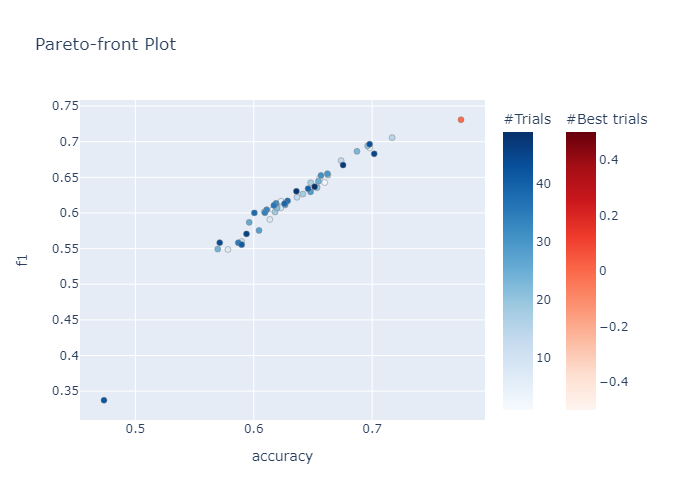

In [25]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [26]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[0], 
    target_name="accuracy"
)
fig.show()

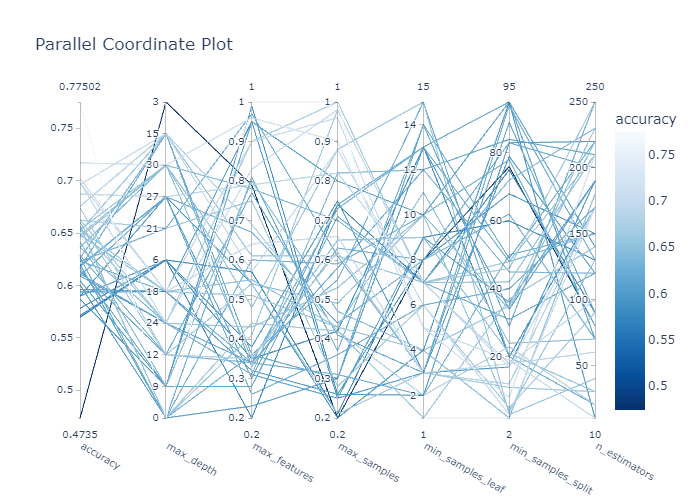

In [27]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [28]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[1], 
    target_name="worst_f1"
)
fig.show()

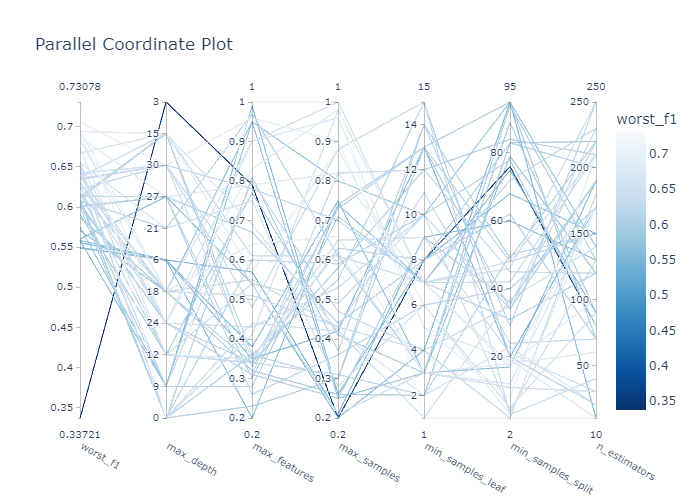

In [29]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

# Random Forest

In [30]:
def rf_search(trials):
    
    def objective(trial):

        model_params = dict(
            n_estimators = trial.suggest_int(
                "n_estimators", 50, 250, 10
            ),
            max_depth = trial.suggest_categorical(
                "max_depth", [*range(3,33,3), None]
            ),
            min_samples_split = trial.suggest_int(
                "min_samples_split", 1,100
            ),
            min_samples_leaf = trial.suggest_int(
                "min_samples_leaf", 1,15
            ),
            max_features = trial.suggest_discrete_uniform(
                "max_features", 0.2, 1.0, 0.01
            ),
        )

        oof_preds, test_preds = score_model(
            RandomForestClassifier(
                n_jobs = -1,
                random_state = RANDOM_SEED,
                **model_params
            )
        )
        return accuracy_score(y_test, test_preds), np.min(f1_score(y_train, oof_preds, average = None))
        
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(directions = ["maximize","maximize"])
    study.enqueue_trial({
        "max_depth": None,
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "n_estimators": 100, 
        "max_features": 1.0,
    })
    study.optimize(objective, n_trials=trials)
    
    return study

In [31]:
study = rf_search(NUM_TRIALS)

[I 2021-12-30 03:22:55,038] A new study created in memory with name: no-name-e1de39cf-4a1f-48c1-af48-663150e94766
[D 2021-12-30 03:22:55,041] Trial 0 popped from the trial queue.


Fold 0 Accuracy: 0.86587 in 3.46s
Fold 1 Accuracy: 0.86349 in 3.58s
Fold 2 Accuracy: 0.87738 in 3.6s
Fold 3 Accuracy: 0.86389 in 3.6s
Fold 4 Accuracy: 0.87262 in 3.56s
Fold 5 Accuracy: 0.87058 in 3.58s

Train Accuracy: 0.86897
Test Accuracy: 0.7519
Training Time: 21.38s


[I 2021-12-30 03:23:17,024] Trial 0 finished with values: [0.751901861305936, 0.7350258811929998] and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}. 


Fold 0 Accuracy: 0.72063 in 1.49s
Fold 1 Accuracy: 0.73056 in 1.47s
Fold 2 Accuracy: 0.72659 in 1.59s
Fold 3 Accuracy: 0.73016 in 1.52s
Fold 4 Accuracy: 0.7246 in 1.49s
Fold 5 Accuracy: 0.73323 in 1.42s

Train Accuracy: 0.72763
Test Accuracy: 0.58178
Training Time: 8.96s


[I 2021-12-30 03:23:26,590] Trial 1 finished with values: [0.5817795943756152, 0.5287485907553552] and parameters: {'n_estimators': 60, 'max_depth': 6, 'min_samples_split': 75, 'min_samples_leaf': 12, 'max_features': 0.27}. 


Fold 0 Accuracy: 0.81429 in 4.23s
Fold 1 Accuracy: 0.81984 in 4.34s
Fold 2 Accuracy: 0.82183 in 4.38s
Fold 3 Accuracy: 0.81984 in 4.39s
Fold 4 Accuracy: 0.81865 in 4.34s
Fold 5 Accuracy: 0.82533 in 4.49s

Train Accuracy: 0.81996
Test Accuracy: 0.67573
Training Time: 26.18s


[I 2021-12-30 03:23:53,372] Trial 2 finished with values: [0.6757302175499609, 0.6703797468354431] and parameters: {'n_estimators': 160, 'max_depth': 27, 'min_samples_split': 42, 'min_samples_leaf': 13, 'max_features': 0.48000000000000004}. 


Fold 0 Accuracy: 0.80952 in 5.52s
Fold 1 Accuracy: 0.82103 in 5.59s
Fold 2 Accuracy: 0.82421 in 5.61s
Fold 3 Accuracy: 0.82421 in 5.6s
Fold 4 Accuracy: 0.81905 in 5.62s
Fold 5 Accuracy: 0.8289 in 5.6s

Train Accuracy: 0.82115
Test Accuracy: 0.67692
Training Time: 33.54s


[I 2021-12-30 03:24:27,517] Trial 3 finished with values: [0.6769177211946428, 0.6687100893997445] and parameters: {'n_estimators': 210, 'max_depth': 12, 'min_samples_split': 42, 'min_samples_leaf': 5, 'max_features': 0.45}. 


Fold 0 Accuracy: 0.72302 in 2.21s
Fold 1 Accuracy: 0.74246 in 2.21s
Fold 2 Accuracy: 0.73214 in 2.2s
Fold 3 Accuracy: 0.7381 in 2.2s
Fold 4 Accuracy: 0.73373 in 2.22s
Fold 5 Accuracy: 0.74514 in 2.23s

Train Accuracy: 0.73576
Test Accuracy: 0.58042
Training Time: 13.28s


[I 2021-12-30 03:24:41,394] Trial 4 finished with values: [0.580415378879046, 0.5398457583547558] and parameters: {'n_estimators': 90, 'max_depth': 6, 'min_samples_split': 49, 'min_samples_leaf': 8, 'max_features': 0.43000000000000005}. 


Fold 0 Accuracy: 0.63214 in 4.73s
Fold 1 Accuracy: 0.64206 in 4.78s
Fold 2 Accuracy: 0.64325 in 4.75s
Fold 3 Accuracy: 0.64683 in 4.81s
Fold 4 Accuracy: 0.62857 in 4.82s
Fold 5 Accuracy: 0.64867 in 4.72s

Train Accuracy: 0.64025
Test Accuracy: 0.38915
Training Time: 28.62s


[I 2021-12-30 03:25:10,616] Trial 5 finished with values: [0.3891495388704225, 0.07586206896551724] and parameters: {'n_estimators': 220, 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 0.55}. 


Fold 0 Accuracy: 0.84484 in 3.73s
Fold 1 Accuracy: 0.84722 in 3.89s
Fold 2 Accuracy: 0.86429 in 3.83s
Fold 3 Accuracy: 0.8504 in 3.85s
Fold 4 Accuracy: 0.85516 in 3.88s
Fold 5 Accuracy: 0.84994 in 3.82s

Train Accuracy: 0.85197
Test Accuracy: 0.7233
Training Time: 22.99s


[I 2021-12-30 03:25:34,219] Trial 6 finished with values: [0.7232957467224369, 0.707157258064516] and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.8800000000000001}. 


Fold 0 Accuracy: 0.72341 in 1.9s
Fold 1 Accuracy: 0.7373 in 1.97s
Fold 2 Accuracy: 0.72738 in 1.89s
Fold 3 Accuracy: 0.73254 in 1.89s
Fold 4 Accuracy: 0.72857 in 1.93s
Fold 5 Accuracy: 0.73243 in 1.95s

Train Accuracy: 0.73027
Test Accuracy: 0.57909
Training Time: 11.52s


[I 2021-12-30 03:25:46,358] Trial 7 finished with values: [0.5790882728713732, 0.5326460481099656] and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 88, 'min_samples_leaf': 8, 'max_features': 0.38}. 


Fold 0 Accuracy: 0.82103 in 6.48s
Fold 1 Accuracy: 0.82341 in 6.43s
Fold 2 Accuracy: 0.83373 in 6.49s
Fold 3 Accuracy: 0.82937 in 6.8s
Fold 4 Accuracy: 0.82222 in 6.41s
Fold 5 Accuracy: 0.83327 in 6.46s

Train Accuracy: 0.82717
Test Accuracy: 0.68442
Training Time: 39.08s


[I 2021-12-30 03:26:26,051] Trial 8 finished with values: [0.6844156050702165, 0.6741116751269035] and parameters: {'n_estimators': 240, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 0.41000000000000003}. 


Fold 0 Accuracy: 0.77262 in 3.56s
Fold 1 Accuracy: 0.78413 in 3.44s
Fold 2 Accuracy: 0.78849 in 3.52s
Fold 3 Accuracy: 0.79048 in 3.61s
Fold 4 Accuracy: 0.78413 in 3.55s
Fold 5 Accuracy: 0.79674 in 3.57s

Train Accuracy: 0.7861
Test Accuracy: 0.63533
Training Time: 21.25s


[I 2021-12-30 03:26:47,912] Trial 9 finished with values: [0.6353285868529917, 0.6170384305294275] and parameters: {'n_estimators': 140, 'max_depth': 9, 'min_samples_split': 75, 'min_samples_leaf': 3, 'max_features': 0.42000000000000004}. 


Fold 0 Accuracy: 0.72619 in 3.03s
Fold 1 Accuracy: 0.73611 in 3.2s
Fold 2 Accuracy: 0.72937 in 3.13s
Fold 3 Accuracy: 0.73294 in 3.11s
Fold 4 Accuracy: 0.72619 in 3.1s
Fold 5 Accuracy: 0.7364 in 3.24s

Train Accuracy: 0.7312
Test Accuracy: 0.57587
Training Time: 18.82s


[I 2021-12-30 03:27:07,367] Trial 10 finished with values: [0.5758650486929507, 0.5295807007466973] and parameters: {'n_estimators': 130, 'max_depth': 6, 'min_samples_split': 77, 'min_samples_leaf': 15, 'max_features': 0.36}. 


Fold 0 Accuracy: 0.80238 in 5.61s
Fold 1 Accuracy: 0.80794 in 5.78s
Fold 2 Accuracy: 0.81468 in 5.78s
Fold 3 Accuracy: 0.81349 in 5.77s
Fold 4 Accuracy: 0.81429 in 5.78s
Fold 5 Accuracy: 0.81659 in 5.76s

Train Accuracy: 0.81156
Test Accuracy: 0.67533
Training Time: 34.47s


[I 2021-12-30 03:27:42,466] Trial 11 finished with values: [0.675327314527658, 0.6637996458386036] and parameters: {'n_estimators': 190, 'max_depth': 21, 'min_samples_split': 65, 'min_samples_leaf': 1, 'max_features': 0.75}. 


Fold 0 Accuracy: 0.77698 in 4.43s
Fold 1 Accuracy: 0.78651 in 4.73s
Fold 2 Accuracy: 0.79683 in 5.12s
Fold 3 Accuracy: 0.78532 in 4.67s
Fold 4 Accuracy: 0.79405 in 4.58s
Fold 5 Accuracy: 0.79079 in 4.69s

Train Accuracy: 0.78841
Test Accuracy: 0.64509
Training Time: 28.22s


[I 2021-12-30 03:28:11,293] Trial 12 finished with values: [0.6450866153142025, 0.6322314049586777] and parameters: {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 70, 'min_samples_leaf': 13, 'max_features': 1.0}. 


Fold 0 Accuracy: 0.81746 in 2.95s
Fold 1 Accuracy: 0.825 in 2.96s
Fold 2 Accuracy: 0.82738 in 2.91s
Fold 3 Accuracy: 0.83175 in 2.9s
Fold 4 Accuracy: 0.81746 in 2.87s
Fold 5 Accuracy: 0.83208 in 2.91s

Train Accuracy: 0.82519
Test Accuracy: 0.6847
Training Time: 17.49s


[I 2021-12-30 03:28:29,400] Trial 13 finished with values: [0.6847018782702737, 0.678544158819038] and parameters: {'n_estimators': 110, 'max_depth': None, 'min_samples_split': 42, 'min_samples_leaf': 9, 'max_features': 0.29000000000000004}. 


Fold 0 Accuracy: 0.64365 in 2.86s
Fold 1 Accuracy: 0.65 in 2.8s
Fold 2 Accuracy: 0.63968 in 2.82s
Fold 3 Accuracy: 0.66032 in 2.8s
Fold 4 Accuracy: 0.62976 in 2.92s
Fold 5 Accuracy: 0.64867 in 2.84s

Train Accuracy: 0.64535
Test Accuracy: 0.49592
Training Time: 17.04s


[I 2021-12-30 03:28:47,060] Trial 14 finished with values: [0.49591883978066525, 0.36267496111975117] and parameters: {'n_estimators': 130, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.22}. 


Fold 0 Accuracy: 0.82817 in 3.52s
Fold 1 Accuracy: 0.83214 in 3.67s
Fold 2 Accuracy: 0.83889 in 3.62s
Fold 3 Accuracy: 0.83333 in 3.64s
Fold 4 Accuracy: 0.83413 in 3.68s
Fold 5 Accuracy: 0.84081 in 3.59s

Train Accuracy: 0.83458
Test Accuracy: 0.70237
Training Time: 21.73s


[I 2021-12-30 03:29:09,396] Trial 15 finished with values: [0.7023712963404742, 0.6920587503111775] and parameters: {'n_estimators': 120, 'max_depth': 24, 'min_samples_split': 38, 'min_samples_leaf': 1, 'max_features': 0.67}. 


Fold 0 Accuracy: 0.78095 in 5.37s
Fold 1 Accuracy: 0.79246 in 5.48s
Fold 2 Accuracy: 0.80357 in 5.47s
Fold 3 Accuracy: 0.79087 in 5.45s
Fold 4 Accuracy: 0.79563 in 5.5s
Fold 5 Accuracy: 0.79754 in 5.48s

Train Accuracy: 0.79351
Test Accuracy: 0.65042
Training Time: 32.74s


[I 2021-12-30 03:29:42,761] Trial 16 finished with values: [0.650419779004158, 0.6404523258802365] and parameters: {'n_estimators': 180, 'max_depth': 30, 'min_samples_split': 69, 'min_samples_leaf': 12, 'max_features': 0.96}. 


Fold 0 Accuracy: 0.83016 in 3.66s
Fold 1 Accuracy: 0.83571 in 3.8s
Fold 2 Accuracy: 0.84484 in 3.71s
Fold 3 Accuracy: 0.84405 in 3.73s
Fold 4 Accuracy: 0.84167 in 3.8s
Fold 5 Accuracy: 0.8424 in 3.64s

Train Accuracy: 0.8398
Test Accuracy: 0.70946
Training Time: 22.34s


[I 2021-12-30 03:30:05,698] Trial 17 finished with values: [0.7094574416011508, 0.6980706589827111] and parameters: {'n_estimators': 130, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.55}. 


Fold 0 Accuracy: 0.81627 in 6.28s
Fold 1 Accuracy: 0.82698 in 6.39s
Fold 2 Accuracy: 0.83452 in 6.35s
Fold 3 Accuracy: 0.82778 in 6.39s
Fold 4 Accuracy: 0.82579 in 6.42s
Fold 5 Accuracy: 0.83168 in 6.35s

Train Accuracy: 0.82717
Test Accuracy: 0.68407
Training Time: 38.2s


[I 2021-12-30 03:30:44,494] Trial 18 finished with values: [0.6840727840775553, 0.6752049180327869] and parameters: {'n_estimators': 230, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 0.56}. 


Fold 0 Accuracy: 0.7254 in 2.9s
Fold 1 Accuracy: 0.73849 in 2.94s
Fold 2 Accuracy: 0.73175 in 2.93s
Fold 3 Accuracy: 0.73016 in 2.85s
Fold 4 Accuracy: 0.72659 in 2.8s
Fold 5 Accuracy: 0.74514 in 2.87s

Train Accuracy: 0.73292
Test Accuracy: 0.58299
Training Time: 17.29s


[I 2021-12-30 03:31:02,389] Trial 19 finished with values: [0.5829936047980802, 0.5368630799886137] and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 0.33}. 


Fold 0 Accuracy: 0.78214 in 7.48s
Fold 1 Accuracy: 0.78929 in 7.63s
Fold 2 Accuracy: 0.79286 in 7.62s
Fold 3 Accuracy: 0.7869 in 7.62s
Fold 4 Accuracy: 0.79563 in 7.6s
Fold 5 Accuracy: 0.79635 in 7.62s

Train Accuracy: 0.79053
Test Accuracy: 0.64918
Training Time: 45.59s


[I 2021-12-30 03:31:48,610] Trial 20 finished with values: [0.6491757275668721, 0.6407666407666408] and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 74, 'min_samples_leaf': 5, 'max_features': 0.99}. 


Fold 0 Accuracy: 0.76984 in 4.84s
Fold 1 Accuracy: 0.77183 in 4.78s
Fold 2 Accuracy: 0.77937 in 4.69s
Fold 3 Accuracy: 0.77698 in 4.71s
Fold 4 Accuracy: 0.77579 in 4.75s
Fold 5 Accuracy: 0.78642 in 4.7s

Train Accuracy: 0.77671
Test Accuracy: 0.62902
Training Time: 28.49s


[I 2021-12-30 03:32:17,698] Trial 21 finished with values: [0.6290235079776566, 0.607743658210948] and parameters: {'n_estimators': 190, 'max_depth': 9, 'min_samples_split': 98, 'min_samples_leaf': 11, 'max_features': 0.36}. 


Fold 0 Accuracy: 0.79167 in 1.84s
Fold 1 Accuracy: 0.80159 in 1.78s
Fold 2 Accuracy: 0.80198 in 1.75s
Fold 3 Accuracy: 0.80317 in 1.79s
Fold 4 Accuracy: 0.80278 in 1.81s
Fold 5 Accuracy: 0.80707 in 1.87s

Train Accuracy: 0.80138
Test Accuracy: 0.65808
Training Time: 10.85s


[I 2021-12-30 03:32:29,147] Trial 22 finished with values: [0.6580767035464301, 0.6553126588713777] and parameters: {'n_estimators': 60, 'max_depth': 15, 'min_samples_split': 74, 'min_samples_leaf': 6, 'max_features': 0.8400000000000001}. 


Fold 0 Accuracy: 0.80794 in 3.25s
Fold 1 Accuracy: 0.81349 in 3.31s
Fold 2 Accuracy: 0.81944 in 3.25s
Fold 3 Accuracy: 0.8119 in 3.29s
Fold 4 Accuracy: 0.81071 in 3.32s
Fold 5 Accuracy: 0.81858 in 3.22s

Train Accuracy: 0.81368
Test Accuracy: 0.66586
Training Time: 19.64s


[I 2021-12-30 03:32:49,410] Trial 23 finished with values: [0.6658573263850233, 0.6624008190427438] and parameters: {'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 42, 'min_samples_leaf': 14, 'max_features': 0.5}. 


Fold 0 Accuracy: 0.82857 in 5.69s
Fold 1 Accuracy: 0.83135 in 5.75s
Fold 2 Accuracy: 0.84286 in 5.77s
Fold 3 Accuracy: 0.8369 in 5.8s
Fold 4 Accuracy: 0.83889 in 5.77s
Fold 5 Accuracy: 0.84438 in 5.79s

Train Accuracy: 0.83716
Test Accuracy: 0.70225
Training Time: 34.57s


[I 2021-12-30 03:33:24,581] Trial 24 finished with values: [0.7022475980441533, 0.6956740442655935] and parameters: {'n_estimators': 210, 'max_depth': None, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.46}. 


Fold 0 Accuracy: 0.79444 in 4.54s
Fold 1 Accuracy: 0.80437 in 4.65s
Fold 2 Accuracy: 0.80913 in 4.68s
Fold 3 Accuracy: 0.80675 in 4.65s
Fold 4 Accuracy: 0.80873 in 4.63s
Fold 5 Accuracy: 0.81421 in 4.78s

Train Accuracy: 0.80627
Test Accuracy: 0.66371
Training Time: 27.92s


[I 2021-12-30 03:33:53,108] Trial 25 finished with values: [0.663708510266075, 0.6592008144566048] and parameters: {'n_estimators': 160, 'max_depth': 21, 'min_samples_split': 64, 'min_samples_leaf': 8, 'max_features': 0.73}. 


Fold 0 Accuracy: 0.82063 in 3.9s
Fold 1 Accuracy: 0.82262 in 3.98s
Fold 2 Accuracy: 0.83175 in 3.99s
Fold 3 Accuracy: 0.82579 in 3.98s
Fold 4 Accuracy: 0.82341 in 4.01s
Fold 5 Accuracy: 0.83287 in 3.99s

Train Accuracy: 0.82618
Test Accuracy: 0.68461
Training Time: 23.84s


[I 2021-12-30 03:34:17,558] Trial 26 finished with values: [0.6846099881072923, 0.6782916350770786] and parameters: {'n_estimators': 150, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 0.37}. 


Fold 0 Accuracy: 0.83056 in 2.22s
Fold 1 Accuracy: 0.83929 in 2.22s
Fold 2 Accuracy: 0.84563 in 2.21s
Fold 3 Accuracy: 0.84127 in 2.26s
Fold 4 Accuracy: 0.83849 in 2.28s
Fold 5 Accuracy: 0.8416 in 2.25s

Train Accuracy: 0.83947
Test Accuracy: 0.71383
Training Time: 13.44s


[I 2021-12-30 03:34:31,609] Trial 27 finished with values: [0.7138292928168399, 0.6964330256921926] and parameters: {'n_estimators': 70, 'max_depth': 24, 'min_samples_split': 23, 'min_samples_leaf': 3, 'max_features': 0.8200000000000001}. 


Fold 0 Accuracy: 0.64643 in 2.66s
Fold 1 Accuracy: 0.65397 in 2.6s
Fold 2 Accuracy: 0.65992 in 2.74s
Fold 3 Accuracy: 0.66389 in 2.69s
Fold 4 Accuracy: 0.63889 in 2.66s
Fold 5 Accuracy: 0.66931 in 2.68s

Train Accuracy: 0.6554
Test Accuracy: 0.46509
Training Time: 16.03s


[I 2021-12-30 03:34:48,242] Trial 28 finished with values: [0.4650932243374631, 0.2777777777777778] and parameters: {'n_estimators': 120, 'max_depth': 3, 'min_samples_split': 94, 'min_samples_leaf': 14, 'max_features': 0.39}. 


Fold 0 Accuracy: 0.62183 in 5.36s
Fold 1 Accuracy: 0.62857 in 5.35s
Fold 2 Accuracy: 0.63532 in 5.44s
Fold 3 Accuracy: 0.64167 in 5.31s
Fold 4 Accuracy: 0.62222 in 5.41s
Fold 5 Accuracy: 0.63279 in 5.43s

Train Accuracy: 0.6304
Test Accuracy: 0.3747
Training Time: 32.3s


[I 2021-12-30 03:35:21,162] Trial 29 finished with values: [0.3746980436230878, 0.006430868167202571] and parameters: {'n_estimators': 240, 'max_depth': 3, 'min_samples_split': 57, 'min_samples_leaf': 14, 'max_features': 0.8900000000000001}. 


Fold 0 Accuracy: 0.62579 in 5.11s
Fold 1 Accuracy: 0.6373 in 5.27s
Fold 2 Accuracy: 0.63571 in 5.25s
Fold 3 Accuracy: 0.64365 in 5.19s
Fold 4 Accuracy: 0.62381 in 5.03s
Fold 5 Accuracy: 0.63716 in 5.32s

Train Accuracy: 0.6339
Test Accuracy: 0.37577
Training Time: 31.17s


[I 2021-12-30 03:35:52,932] Trial 30 finished with values: [0.3757724516825619, 0.02439024390243903] and parameters: {'n_estimators': 230, 'max_depth': 3, 'min_samples_split': 63, 'min_samples_leaf': 10, 'max_features': 0.72}. 


Fold 0 Accuracy: 0.83294 in 4.43s
Fold 1 Accuracy: 0.83294 in 4.42s
Fold 2 Accuracy: 0.84683 in 4.4s
Fold 3 Accuracy: 0.83651 in 4.39s
Fold 4 Accuracy: 0.83532 in 4.7s
Fold 5 Accuracy: 0.84597 in 4.78s

Train Accuracy: 0.83842
Test Accuracy: 0.70649
Training Time: 27.12s


[I 2021-12-30 03:36:20,653] Trial 31 finished with values: [0.7064886824894459, 0.7018696311268318] and parameters: {'n_estimators': 170, 'max_depth': 15, 'min_samples_split': 22, 'min_samples_leaf': 7, 'max_features': 0.21000000000000002}. 


Fold 0 Accuracy: 0.8127 in 6.12s
Fold 1 Accuracy: 0.81468 in 6.16s
Fold 2 Accuracy: 0.82897 in 6.22s
Fold 3 Accuracy: 0.82103 in 6.17s
Fold 4 Accuracy: 0.82183 in 6.3s
Fold 5 Accuracy: 0.82136 in 6.13s

Train Accuracy: 0.82009
Test Accuracy: 0.68001
Training Time: 37.09s


[I 2021-12-30 03:36:58,344] Trial 32 finished with values: [0.6800137128397065, 0.6729399796541201] and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 21, 'min_samples_leaf': 13, 'max_features': 0.9000000000000001}. 


Fold 0 Accuracy: 0.80833 in 4.41s
Fold 1 Accuracy: 0.8127 in 4.43s
Fold 2 Accuracy: 0.81984 in 4.47s
Fold 3 Accuracy: 0.81786 in 4.3s
Fold 4 Accuracy: 0.81151 in 4.4s
Fold 5 Accuracy: 0.82295 in 4.41s

Train Accuracy: 0.81553
Test Accuracy: 0.67304
Training Time: 26.43s


[I 2021-12-30 03:37:25,380] Trial 33 finished with values: [0.6730424302827567, 0.6680254777070064] and parameters: {'n_estimators': 170, 'max_depth': 30, 'min_samples_split': 56, 'min_samples_leaf': 10, 'max_features': 0.32}. 


Fold 0 Accuracy: 0.62738 in 3.95s
Fold 1 Accuracy: 0.63571 in 3.86s
Fold 2 Accuracy: 0.6373 in 3.86s
Fold 3 Accuracy: 0.64365 in 3.89s
Fold 4 Accuracy: 0.62262 in 3.92s
Fold 5 Accuracy: 0.63914 in 3.99s

Train Accuracy: 0.6343
Test Accuracy: 0.38257
Training Time: 23.47s


[I 2021-12-30 03:37:49,457] Trial 34 finished with values: [0.3825740908617, 0.04085257548845471] and parameters: {'n_estimators': 180, 'max_depth': 3, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 0.6799999999999999}. 


Fold 0 Accuracy: 0.77778 in 6.37s
Fold 1 Accuracy: 0.78452 in 6.48s
Fold 2 Accuracy: 0.79087 in 6.48s
Fold 3 Accuracy: 0.78413 in 6.5s
Fold 4 Accuracy: 0.79008 in 6.57s
Fold 5 Accuracy: 0.79516 in 6.53s

Train Accuracy: 0.78709
Test Accuracy: 0.65297
Training Time: 38.94s


[I 2021-12-30 03:38:28,994] Trial 35 finished with values: [0.6529679639083714, 0.6391594054331112] and parameters: {'n_estimators': 210, 'max_depth': 24, 'min_samples_split': 83, 'min_samples_leaf': 6, 'max_features': 0.99}. 


Fold 0 Accuracy: 0.7869 in 2.31s
Fold 1 Accuracy: 0.79841 in 2.3s
Fold 2 Accuracy: 0.79524 in 2.32s
Fold 3 Accuracy: 0.79722 in 2.32s
Fold 4 Accuracy: 0.79325 in 2.31s
Fold 5 Accuracy: 0.8023 in 2.32s

Train Accuracy: 0.79556
Test Accuracy: 0.64607
Training Time: 13.88s


[I 2021-12-30 03:38:43,474] Trial 36 finished with values: [0.6460655989736576, 0.6279193205944799] and parameters: {'n_estimators': 90, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 0.34}. 


Fold 0 Accuracy: 0.78889 in 5.79s
Fold 1 Accuracy: 0.79325 in 5.75s
Fold 2 Accuracy: 0.79762 in 5.78s
Fold 3 Accuracy: 0.80079 in 5.79s
Fold 4 Accuracy: 0.79048 in 5.79s
Fold 5 Accuracy: 0.80667 in 5.75s

Train Accuracy: 0.79628
Test Accuracy: 0.65313
Training Time: 34.64s


[I 2021-12-30 03:39:18,750] Trial 37 finished with values: [0.6531340730491453, 0.645774466992037] and parameters: {'n_estimators': 230, 'max_depth': 12, 'min_samples_split': 92, 'min_samples_leaf': 11, 'max_features': 0.29000000000000004}. 


Fold 0 Accuracy: 0.77976 in 4.05s
Fold 1 Accuracy: 0.78095 in 4.2s
Fold 2 Accuracy: 0.7873 in 4.27s
Fold 3 Accuracy: 0.79048 in 4.39s
Fold 4 Accuracy: 0.78413 in 4.18s
Fold 5 Accuracy: 0.79238 in 4.24s

Train Accuracy: 0.78583
Test Accuracy: 0.64473
Training Time: 25.35s


[I 2021-12-30 03:39:44,707] Trial 38 finished with values: [0.6447331916104281, 0.6341589267285862] and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 99, 'min_samples_leaf': 8, 'max_features': 0.75}. 


Fold 0 Accuracy: 0.83849 in 2.13s
Fold 1 Accuracy: 0.84087 in 2.17s
Fold 2 Accuracy: 0.85278 in 2.18s
Fold 3 Accuracy: 0.84643 in 2.13s
Fold 4 Accuracy: 0.84603 in 2.18s
Fold 5 Accuracy: 0.84637 in 2.15s

Train Accuracy: 0.84516
Test Accuracy: 0.71809
Training Time: 12.94s


[I 2021-12-30 03:39:58,255] Trial 39 finished with values: [0.718091582684359, 0.7050931677018634] and parameters: {'n_estimators': 70, 'max_depth': 18, 'min_samples_split': 21, 'min_samples_leaf': 3, 'max_features': 0.67}. 


Fold 0 Accuracy: 0.81071 in 3.01s
Fold 1 Accuracy: 0.8131 in 3.07s
Fold 2 Accuracy: 0.81905 in 3.09s
Fold 3 Accuracy: 0.81468 in 3.03s
Fold 4 Accuracy: 0.81349 in 3.08s
Fold 5 Accuracy: 0.82255 in 3.02s

Train Accuracy: 0.8156
Test Accuracy: 0.67673
Training Time: 18.3s


[I 2021-12-30 03:40:17,171] Trial 40 finished with values: [0.6767268723946046, 0.6676729559748428] and parameters: {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 55, 'min_samples_leaf': 3, 'max_features': 0.72}. 


Fold 0 Accuracy: 0.79484 in 2.13s
Fold 1 Accuracy: 0.79286 in 2.11s
Fold 2 Accuracy: 0.7996 in 2.11s
Fold 3 Accuracy: 0.80833 in 2.16s
Fold 4 Accuracy: 0.79603 in 2.15s
Fold 5 Accuracy: 0.81382 in 2.1s

Train Accuracy: 0.80091
Test Accuracy: 0.65831
Training Time: 12.76s


[I 2021-12-30 03:40:30,530] Trial 41 finished with values: [0.6583117303094401, 0.6560202788339671] and parameters: {'n_estimators': 80, 'max_depth': 15, 'min_samples_split': 89, 'min_samples_leaf': 7, 'max_features': 0.42000000000000004}. 


Fold 0 Accuracy: 0.82103 in 3.29s
Fold 1 Accuracy: 0.81984 in 3.25s
Fold 2 Accuracy: 0.82262 in 3.31s
Fold 3 Accuracy: 0.82738 in 3.33s
Fold 4 Accuracy: 0.81706 in 3.23s
Fold 5 Accuracy: 0.83406 in 3.31s

Train Accuracy: 0.82367
Test Accuracy: 0.69022
Training Time: 19.73s


[I 2021-12-30 03:40:50,869] Trial 42 finished with values: [0.6902205894047108, 0.6805] and parameters: {'n_estimators': 120, 'max_depth': 18, 'min_samples_split': 54, 'min_samples_leaf': 1, 'max_features': 0.4}. 


Fold 0 Accuracy: 0.76389 in 6.63s
Fold 1 Accuracy: 0.77579 in 6.69s
Fold 2 Accuracy: 0.78254 in 6.71s
Fold 3 Accuracy: 0.77976 in 6.76s
Fold 4 Accuracy: 0.77421 in 6.8s
Fold 5 Accuracy: 0.78404 in 6.68s

Train Accuracy: 0.77671
Test Accuracy: 0.64127
Training Time: 40.27s


[I 2021-12-30 03:41:31,748] Trial 43 finished with values: [0.6412696393134392, 0.6263510036026763] and parameters: {'n_estimators': 230, 'max_depth': 30, 'min_samples_split': 98, 'min_samples_leaf': 14, 'max_features': 0.9099999999999999}. 


Fold 0 Accuracy: 0.71944 in 1.19s
Fold 1 Accuracy: 0.73849 in 1.34s
Fold 2 Accuracy: 0.73333 in 1.32s
Fold 3 Accuracy: 0.73254 in 1.19s
Fold 4 Accuracy: 0.73175 in 1.42s
Fold 5 Accuracy: 0.73918 in 1.34s

Train Accuracy: 0.73246
Test Accuracy: 0.57857
Training Time: 7.8s


[I 2021-12-30 03:41:40,155] Trial 44 finished with values: [0.5785722742638626, 0.534596612115992] and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 56, 'min_samples_leaf': 9, 'max_features': 0.53}. 


Fold 0 Accuracy: 0.80992 in 3.17s
Fold 1 Accuracy: 0.81905 in 3.1s
Fold 2 Accuracy: 0.81865 in 3.24s
Fold 3 Accuracy: 0.81706 in 3.09s
Fold 4 Accuracy: 0.81111 in 3.09s
Fold 5 Accuracy: 0.82612 in 3.07s

Train Accuracy: 0.81699
Test Accuracy: 0.67021
Training Time: 18.77s


[I 2021-12-30 03:41:59,535] Trial 45 finished with values: [0.670207972178486, 0.6675191815856777] and parameters: {'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 42, 'min_samples_leaf': 13, 'max_features': 0.31}. 


Fold 0 Accuracy: 0.80873 in 6.06s
Fold 1 Accuracy: 0.81627 in 6.26s
Fold 2 Accuracy: 0.8254 in 6.12s
Fold 3 Accuracy: 0.82302 in 6.16s
Fold 4 Accuracy: 0.81944 in 6.22s
Fold 5 Accuracy: 0.82692 in 6.17s

Train Accuracy: 0.81996
Test Accuracy: 0.68278
Training Time: 37.0s


[I 2021-12-30 03:42:37,145] Trial 46 finished with values: [0.6827810204402599, 0.6717019133937563] and parameters: {'n_estimators': 210, 'max_depth': None, 'min_samples_split': 54, 'min_samples_leaf': 2, 'max_features': 0.66}. 


Fold 0 Accuracy: 0.81071 in 3.66s
Fold 1 Accuracy: 0.82143 in 3.75s
Fold 2 Accuracy: 0.83294 in 3.81s
Fold 3 Accuracy: 0.82698 in 3.71s
Fold 4 Accuracy: 0.82341 in 3.8s
Fold 5 Accuracy: 0.83009 in 3.75s

Train Accuracy: 0.82426
Test Accuracy: 0.68337
Training Time: 22.49s


[I 2021-12-30 03:43:00,244] Trial 47 finished with values: [0.6833659366700066, 0.6756345177664975] and parameters: {'n_estimators': 130, 'max_depth': 30, 'min_samples_split': 30, 'min_samples_leaf': 12, 'max_features': 0.66}. 


Fold 0 Accuracy: 0.82976 in 3.64s
Fold 1 Accuracy: 0.83214 in 3.72s
Fold 2 Accuracy: 0.84206 in 3.68s
Fold 3 Accuracy: 0.8381 in 3.66s
Fold 4 Accuracy: 0.84127 in 3.73s
Fold 5 Accuracy: 0.84438 in 3.77s

Train Accuracy: 0.83795
Test Accuracy: 0.70399
Training Time: 22.2s


[I 2021-12-30 03:43:23,072] Trial 48 finished with values: [0.7039882097852421, 0.6947579633809883] and parameters: {'n_estimators': 130, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.54}. 


Fold 0 Accuracy: 0.78651 in 5.24s
Fold 1 Accuracy: 0.79246 in 5.28s
Fold 2 Accuracy: 0.79643 in 5.31s
Fold 3 Accuracy: 0.8004 in 5.31s
Fold 4 Accuracy: 0.79524 in 5.42s
Fold 5 Accuracy: 0.80707 in 5.36s

Train Accuracy: 0.79635
Test Accuracy: 0.65199
Training Time: 31.92s


[I 2021-12-30 03:43:55,591] Trial 49 finished with values: [0.6519854460118786, 0.6441717791411042] and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 93, 'min_samples_leaf': 11, 'max_features': 0.48000000000000004}. 


In [32]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_pareto_front(study, target_names=["accuracy",'f1'])
fig.show()

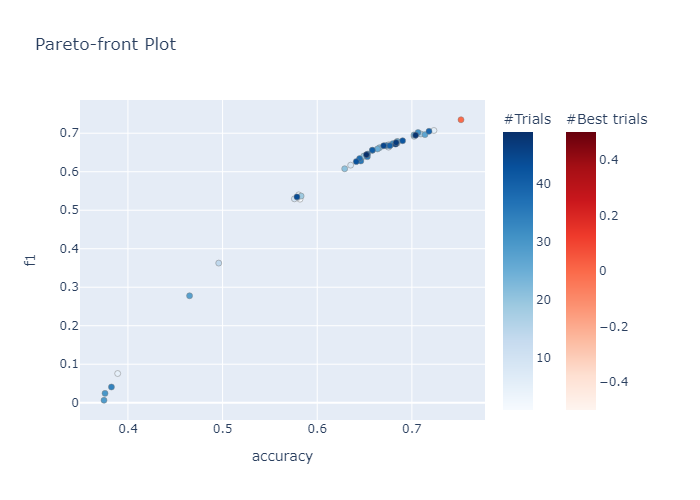

In [33]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [34]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[0], 
    target_name="accuracy"
)
fig.show()

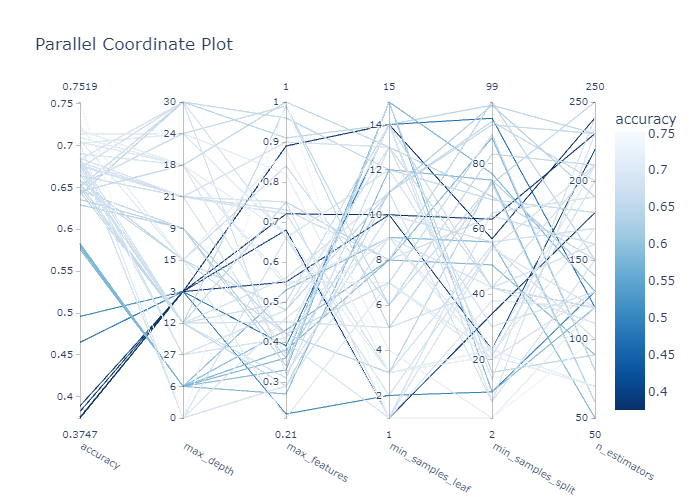

In [35]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [36]:
# Interative version (won't work on github)
fig = optuna.visualization.plot_parallel_coordinate(
    study, 
    target=lambda t: t.values[1], 
    target_name="worst_f1"
)
fig.show()

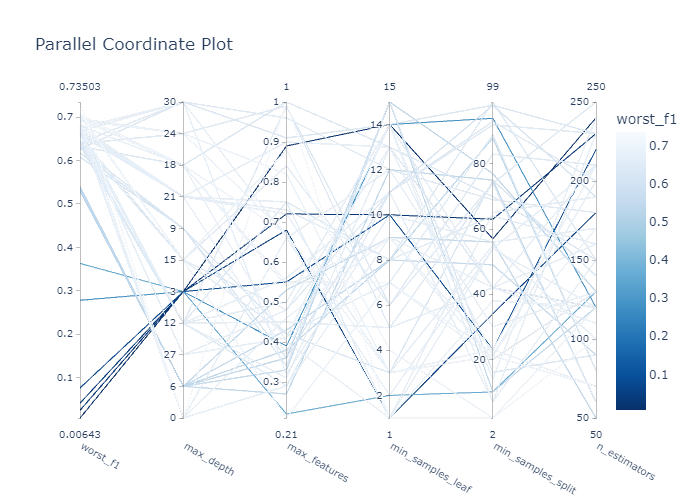

In [37]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)